## This is a script to perform text clustering on DanishParliamentCorpus data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
# nltk.download("punkt") # Download if not already downloaded (needed for sentence tockenizeing).

Read in data and Danish stop words.

In [2]:
df = pd.read_csv('C:/Users/Bjorn/OneDrive/Dokument/University/DTU/02582 Computational Data Analysis/labs/02582-Computational-Data-Analysis-/Case2/DPC_speeches.csv', delimiter=",")
df = df.reset_index().iloc[:,2:]
# read in stop words for danish as a list.
# with open('C:/Users/Bjorn/OneDrive/Dokument/University/DTU/02582 Computational Data Analysis/labs/02582-Computational-Data-Analysis-/Case2/data/stopord.txt') as f:
#     stopord = [word for line in f for word in line.split()]]

stopord_ = pd.read_csv("C:/Users/Bjorn/OneDrive/Dokument/University/DTU/02582 Computational Data Analysis/labs/02582-Computational-Data-Analysis-/Case2/data/stopord.txt")    
stopord = []
for i in stopord_["ad"]:
    stopord.append(i)

In [3]:
df.count() # 236 966 observations, each feature is equal i.e. no NAs
df = df[['Starttid', 'Sluttid', 'Navn', 'Rolle', 'Tekst']] # Since "Tale" feature is irrelevant it can be disregarded.

## Add parties to politicians

To be able to cluster and view differences between texts said by various politicians we need to add the party to the given person. There were some people that were not associated to any party, so I mathched the party to the given person manually and saved a new csv file called fm3.csv

In [4]:

# Add parties to politicians
ft_mem = pd.read_csv('C:/Users/Bjorn/OneDrive/Dokument/University/DTU/02582 Computational Data Analysis/labs/02582-Computational-Data-Analysis-/Case2/fm3.csv')

#checking how many unique names in our dataset
xml = list(df.Navn.unique())
len(xml)
#Checking how many names in the ft dataset
ft = list(ft_mem.Spørger.unique())
ft = [x[0:-1] for x in ft] #removing whitespace in the end of every name
len(ft)
#making a list of the set values
set_ = list(set(xml) & set(ft))
#removing whitespace in the end of every name
ft_mem['Spørger'] = ft_mem['Spørger'].apply(lambda x: x[0:-1])
#filtering out the names that we are looking for which are matching in the list of FT members
match = ft_mem[ft_mem['Spørger'].isin(set_)]
match.head()
#merging the two dataframes
df_m = df.merge(match, left_on = "Navn", right_on = "Spørger", how='left')
#looking only at specific columns
df_m = df_m[['Starttid', 'Sluttid', 'Navn', 'Rolle', 'Tekst', 'Parti']]
#only looking at relevant names
df_m = df_m[df_m.Navn!='None']
#checking which names does not have a party
df_m[df_m.isnull().Parti].Navn.unique() # There are now no people without parties
df_m = df_m[~((df_m['Navn'] == ', fg.'))] # Delete observation that doesnt make sense.


Check to see if any values in any observations are missing.

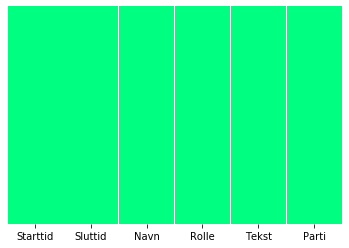

In [5]:
sns.heatmap(df_m.isnull(), yticklabels=False, cbar=False, cmap="winter_r")

In [6]:
# Inserting Dates
#making dates into datetime
df_m.Starttid = pd.to_datetime(df_m.Starttid)
df_m.Sluttid = pd.to_datetime(df_m.Sluttid)
#creating a date columns
df_m['Dato'] = df_m.Starttid.dt.date
#and keeping start and endtime to a time variable
df_m['Starttid'] = df_m['Starttid'].dt.time
df_m['Sluttid'] = df_m['Sluttid'].dt.time

df_m["Tekst"][1]

text = df_m["Tekst"].str.cat(sep=" ") # put all text instances from all rows into one string.
Tekst_tot = nltk.tokenize.sent_tokenize(text) # put all individual sentences from all rows into one list.


Put all text instances from all rows into list, then seperate split into stings by sentence. 

In [5]:
#Tekst_tot = df["Tekst"].str.cat(sep=" ") # put all text instances from all rows into one string.
#Tekst_tot = Tekst_tot.split(".")[1:-1] # Split the full text string into many small strings after periods(sentences). 

Use TfidfVectorizer and KMeans to create a model and fit the model to produce clusters from the text data.

In [6]:
# Use TfidfVectorizer to create class to fit and transform document.
vectorizer = TfidfVectorizer(stop_words=stopord)
X = vectorizer.fit_transform(Tekst_tot)
true_k = 35 # Not sure how many clusters is appropriate for our task. 
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=1)
model.fit(X)

# get the centroids and features.
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

C:\Users\Bjorn\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Check which words each cluster contains. It can be seen that some common stop words are not in the stopord list, for example "altså". 

In [8]:
# print the centroids into which clusters they belongs
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: morten østergaard bødskov marinus bemærkning hr kort ordfører radikale siger
Cluster 1: nr stemmes ændringsforslag vedtagelse ønskes afstemning endelige beslutningsforslag lovforslagets forslag
Cluster 2: 65 år pct mio mia 000 regeringen dag stemte ældre
Cluster 3: tak hr ordfører formand ordet venstres spørgsmålet radikale sf socialdemokratiske
Cluster 4: hr spørge ordfører tror gerne første spørger høre spørgsmål enig
Cluster 5: nærmere gerne udvalgsbehandlingen kigge udvalgsarbejdet ministeren tror undersøge belyst gå
Cluster 6: 000 kr arbejdspladser personer job mennesker arbejdsløse nye mia mio
Cluster 7: svaret tak spørgsmål spørgsmålet ministeren hr svar gerne set ordføreren
Cluster 8: varehuse landdistriktsordfører ødelagde holstebro bygge mulighederne sidder socialdemokratiet landet spørgeren
Cluster 9: 30 pct år mia 000 20 mio dage altså 40
Cluster 10: bemærkning kort hr fru korte yderligere enkelt bedt spørgeren barfod
Cluster 11: værsgo ordføreren spørgeren minis

In [25]:
#len(terms)
# Check the names of all words in first centroid.
for ind in order_centroids[4]:
        print(' %s' % terms[ind], end='')

 hr spørge ordfører tror gerne første spørger høre spørgsmål enig siger jamen mener forstår glad altså går håber rigtigt sikker sagde hører sagt svar ting taler hørt står give ønsker nødt faktisk interessant kender konstatere egentlig nævnte forhold både klar spørgsmålet svare korrekt bekræfte muligt stille giver tænke starte virkeligheden tvivl præcis rigtig betyder måde følge hensyn sidste ønske problemet blot gælder selvfølgelig uanset tager vigtigt forslag dag handler fint sagen netop enkelt vel enige klart inden dengang gang virker stillet svært simpelt sammenhæng lade diskussion ordet del desværre situation debat folkeparti opmærksom forskel vist hverken vide afgørende dansk sker regering nå gået sidder ord udtryk socialdemokratiet spørgeren tidspunkt bemærkninger problem venstres grund sikre regeringen eksempel gik finder virkelig samtidig sag væk forbindelse ligger penge holder plads trods bestemt hjælpe opfattelse tale stiller positivt tal hvilket verden bruger beslutningsfors

 gymnasieforligskredsen gymnasieforliget gymnasiefolk gymnasiefesten gymnasiefest gylletransporter gylletankene gylletanke gylletank gyllebarriere gylleanlæg gylleaftaler gylle gyldne gyldigt gyldighedstiden gyldighedstid gyldighedsrettigheder gyldighedsperioden gyldighedsperiode gyldighedsbetingelser gyldigheden gyldighed gyldige gyllebarrierer gyllebeholder gyllebeholdere gyllelugten gylleseparering gyllerender gylleproblemet gyllenedkøling gyllen gyllelæk gylleloven gyllebeholderen gyllelov gyllekøling gyllekumme gylleforurening gyllebeholderne gyllebeholderens gymnasiekredsen gymnasieloven gymnasielovens gymnasieskolers gymnastik gymnaster gymnasiums gymnasium gymnasieverden gymnasievejen gymnasievalg gymnasieuddannelserne gymnasieuddannelser gymnasieuddannelsen gymnasieuddannelse gymnasiets gymnasietiden gymnasietid gymnasiet gymnastikhøjskole gymnastikken gymnastiksalen gynækologi gästen gyser gyselige gyse gynækologiske gynækologisk gynækologer gynge gynækolog gyngestativ gynger

 glædestårer gnave glædesudbrud gnaske gn gmo gmes gme gmail gm gløgg gløder glødepærer glødende glødelamper glødelampen glød glædet godhedens godheds godhedsdyrkelse godmodig godkendt godkendes godkender godkendende godkendelsestiden godkendelsessystemet godkendelsessystem godkendelsesstempel godkendelsesregler godkendelsesreformen godkendelsesreform godkendelsesprocessen godkendelsesproces godkendelsesprocedurer godkendelsesproceduren godkendte godmodige godhedsindustri godmorgen godsejere godsejer godschaufførernes godschaufførerne godsbefordring godsbane godsafsenderne godsafsendere godsafgift gods godp godot godnatlæsning godnathistorier godnat godkendelsesprocedure godkendelsespraksis godkendelsespligtige godkendelsesperioden godkendelseskompetencen godkendelsesgrænsen godkendelsesfristerne godkendelsesforløb godkendelsesbekendtgørelsens godkendelses godkendelserne godkendelser godkendelsens godkendelsen godkendelse godkende godhjertet godhjertede godhedsindustriens godkendelsesk

 ghettoboligområde ghettoblastere ghettobetjente ghettobekæmpelse ghettobegrebet ghettobegreb ghettoaftalen ghettoaftale ghetto ghellab ghanavenskabsgruppe ghana ghalioun gggi ghettodannelse ghettodannelser gerningssted ghettodebat ghettoiseringstendens ghettoiseringen ghettoisering ghettoindsatsen ghettoindsats ghettofænomen ghettoforhandlingerne ghettoerne ghettoer ghettoen ghettodiskussionen ghettodefinitionerne ghettodefinitionen ghettodefinition ghettodebatten geværløbet geværkolber geværer gevær gestus gestikulerede gesta geskæftig gesimser geschæft geschrei geråder geråde gertrud gert gerningstidspunktet gerningsstedet gerningsstederne gerningssteder gesvindt get get2sport gevinst gevinstpotentiale gevinstgivende gevinstforøgelse gevinsterne gevinster gevinsten gevind geus gevandter gevaliakaffe gevalia gevaldigt gevaldige gevaldig genèvekonventionerne genèvekonventionen ghettokriterier gentagelsessynd gentagelseskriminelle gentagelseskriminaliteten gentagelseskriminalitet genta

 grundbevillinger grundbevilling grundbetragtning grundbetingelserne grundbestemmelse grundbeskyttelse grundberegningerne grundambitionen grundbeløbet grundbeløb grundbelysning grundbegreb grundantagelser grundantagelse grimmere grimme grundfaget gravpladsen gravpasning gravmæler gravminderegistreringen gravminderegistrering gravminder gravlagt gravkøerne gravjagttræning gravjagten gravjagt graviditetssamtale graviditetsperioden graviditetsperiode graviditetsområdet graviditetsforhold gravplads gravpladser greencardet gravsted greencard green greco grebningen grebet greb great gravsten gravstedskapitalerne gravstedskapitaler gravstedskapitalen gravstedkapitaler gravstedet gravstederne gravsteder graviditetsdirektivet graviditetsbetinget graviditeter graviditeten gravemaskinerne gravemaskinen gravede gravearbejdet gravearbejder gravearbejde graveaktørernes graveaktørerne graveaktører grave gravalvorligt grav graugaards gratulerer gratulere graven graveomkostninger graver gravhund gravid

 hvoraf hvo hvisket hvisker hviskeniveau hviskende hviskede hviske hvirvlet hvirvles hvirvler hvilepauser hvilende hvilemuligheder hvileløst hvidtning hvidtede hvidte hvidt hvidstengruppen hvidovres hvidovreprojekt hvidovreområdet hvidovre hvidkål hvidhåret hvidglødende hvidevarer hvides hviderussiske hvidvask hvidvaske hvidvasker hvidvinen hvileløse hvilede hvile hvil hviket hviid hvidvin hvidvasket hvidvaskregler hvidvaskningsloven hvidvaskningsdirektiv hvidvaskning hvidvasklovens hvidvaskloven hvorigennem hvorledes hvideruslands hygiejne hyggetid hygget hyggestøtte hyggesnakker hyggesnakke hyggesnak hyggesammenkomster hyggeregning hygger hyggepianist hyggens hyggen hyggelæsning hyggeligt hyggeligste hyggeår hygiejnebevis hvormed hygiejnebind hygiejneorganisationer hygiejneorganisation hygiejneområdet hygiejneniveauet hygiejnen hygiejnemæssigt hygiejnemæssige hygiejnekursus hygiejnekurser hygiejnekrav hygiejneindsatser hygiejnefærdigheder hygiejneeksperterne hygiejneeksperter hygiejn

 højlydt højhastighedsforbindelser højrenationalistiske højrekræfter højrehøjreregering højrefløjsregeringen højrefløjsregering højrefløjspolitiker højrefløjspartierne højrefløjspartier højrefløjsekstremisme højrefløjsargument højrefløjens højrefløjen højrefløj højreekstremistiske højreekstremisterne højreekstremisme højreligiøst højreorienterede højlydte højreorienteredes højrisikoankomsterne højrisikoankomster højrisikoankomsten højrisikoafgange højrisiko højreudskridning højresvingsulykkerne højresvingsulykker højresving højreskøjten højresiden højreradikale højrepopulistiske højrepopulisme højreorienteret højreekstreme højreekstrem højredrejning højredrejet højniveaumødet højniveaumøde højniveauforløb højniveaufag højniveau højnet højnes højner højnelse højnede højne højmølle højmoseprojektet højmobilt højlys højniveaupanel højniveaupolitiske højniveausegmentet højprioritetsområde højrebenet højre højprofileret højprofilerede højproduktive højprismarked højprioritere højniveauspor 

 hjemmelbestemmelsen hjemmelivet hjemløsestrategien hjemmestrikkede hjemmesideudbyderne hjemmesidetekster hjemmesiderne hjemmesider hjemmesiden hjemmeside hjemmeserviceydelser hjemmeservicevirksomheder hjemmeserviceordningen hjemmeserviceordning hjemmeservicen hjemmeservicelignende hjemmeservicefirma hjemmeservicedelen hjemmeservice hjemmestraf hjemmestyre hjemmelsbestemmelse hjemmestyreaftaler hjemmetilbud hjemmet hjemmesygeplejerskerne hjemmesygeplejersker hjemmesygeplejersken hjemmesygeplejerske hjemmesygeplejen hjemmesygepleje hjemmestyrets hjemmestyret hjemmestyres hjemmestyreordningen hjemmestyrelovgivning hjemmestyrelovens hjemmestyreloven hjemmerøverne hjemmerøveriet hjemmerøverierne hjemmerøverier hjemmene hjemmen hjemmemiljø hjemmemarkedsorienterede hjemmemarkedserhvervene hjemmemarkedserhverv hjemmemarkedet hjemmemarkeder hjemmemarked hjemmelæsning hjemmelsmænd hjemmelsloven hjemmelsgrundlaget hjemmelsgrundlag hjemmelsbestemmelser hjemmeopgaver hjemmeorienterede hjemmepleje 

 hotelværelse hotelvirksomheder hotelvirksomhed hoteludlejningen hotelgang hotelfunktion hotelfag hotelerhvervets hospitalsvalg hospitalsundersøgelse hospitalsudvidelser hospitalsudstyr hospitalsuddannet hospitalstilbud hospitalstider hospitalssystemet hospitalsstuer hospitalssenge hospitalsseng hospitalssektoren hospitalssammenhæng hospitalsregninger hospitalsregi hospitalsverdenen hospitalsvæsen hospitalsvæsenet hotdog hotelerhvervet hotelerhverv hotelejer hotelbranchen hotel hotdogs hotbun host hot hostmaster hoster hosten hosteanfald hoste hose hortensiastriden hotspotindsatser honoreret honorerer honorerede honorere honorer honorarstøttede honorarstøtte honorarmodtagernes honorarmodtagere honorarmodtager honorarets honoraret honorarerne honorarer honorar honnør honoreres honorering hoover honoreringen hooligans hooliganregistret hooliganregistre hooliganregisteret hooliganregister hooliganproblematikken hooliganlovgivning hooliganlovens hooliganloven hooliganlov hooligankonference

 hofteprotesen hoftepatienter hofteopereret hofteoperationer hofteoperation hofteområdet hoften hofteimplantater hoftebrud hokkerup hokus hokuspokus hokuspokustal holbæk holbergskolens holbergskolen holbergs holberg hokuspokusøkonomi hokuspokussvar hokuspokusargumentation hokuspokussnak hokuspokusregning hokuspokuspenge hokuspokusløsning hokuspokusberegning hokuspokusargumentationen genset genoptjeningsreglen gensekvenser forsøgsbasis forsøgsansøgning forsøgsansvarlige forsøgsanlægget forsøgsanlæg forsøgs forsøgets forsøget forsøges forsøgere forsøger forsøgene forsøge forsøg forsødet forsøde forsøgsarbejde forsøgsbehandling forsætter forsøgsbestemmelser forsøgsgruppen forsøgsforslag forsøgsform forsøgsfiskeriet forsøgsfiskeri forsøgsfarme forsøgsfacilitet forsøgselementet forsøgsdyrsområdet forsøgsdyrsdirektivet forsøgsdyret forsøgsdyrene forsøgsdyr forsøgsdata forsøgsbevillingerne forsættet forsætte forsørgelsesbehov forsyningsteknologi forsyningssikkert forsyningssikkerhedssikkerhed

 fosforbomber fosfor forøvrigt forøvet forøver forøget forøger foræring forøgelser forøgelsen forøgelse forøgede forøge foræringer fosteret fosterreduktion fradragsadgang foundation fotovognen fotovogne fotovogn fotoudstyret fotoudstyr fotos fotoredigerede fotooptagelse fotomodel fotomateriale fotomaskiner fotomanipulation fotokopierer fotokopi fotokontrol foulum fouroozandeh fosterskadende foventningen fradrags fradragets fradraget fradrages fradrager fradragene fradrage fradrag fradanmarks fraciska frabedt frabeder frabede fraa fox fotokonkurrencer fotografiske fotografier fotografi fotoapparat fotoalbum foto fot fostret fostres fostrer fostrene fostrede fostre fostertilstanden fostertilstand fosterstilling fosterstadiet fosterskader fotoapparatet fotoceller fotodokumentation fotografen fotografering fotograferet fotograferes fotograferer fotografere fotografer fotograf fotoet fotofælder fotofælde fotoforbudszoner fotoforbud fotofartfælder fotofartfælde frakendelsestiden frakendelses

 forhandlingsmuligheden forhandlingsmulighed forhandlingsmodus forhandlingsmodpart forhandlingsmodellen forhandlingsmodel forhandlingsmetoder forhandlingsmateriale forhandlingsmandatet forhandlingssituationen forhandlingssituationer forhandlingsskik forhindringer forhindring forhindret forhindres forhindrer forhindrende forhindrede forhindre forherliget forherliges forherliger forherligelse forherlige forhenværende forhen forhaverne forhindringen forhindringerne forhandlingsspil forhindringsbane forholder forholdenes forholdene forholden forholdelsesmåde forhistoriske forhistorisk forhistorien forhistorie forhippet forhippelse forhippede forhindringsmulighed forhindringsløb forhindringsforløb forhaven forhave forhastet forhaster forhandlingstid forhandlingstekniske forhandlingsteknik forhandlingsteam forhandlingstaktik forhandlingssystem forhandlingssynspunkt forhandlingsstyrke forhandlingsstræk forhandlingsstrategi forhandlingsstof forhandlingsspørgsmål forhandlingssporet forhandlings

 forpjusket forpinte forpint forpestet forpester forordningsudkastet forordningsgrundlaget forordningsgennemførelse forordningsforslaget fornøjelserne fornøjelser fornøjelsen fornøjelse fornøjeligt fornøjelige fornøjelig fornøjede fornøje fornødne fornødent fornødenheder fornøden fornærmethed fornærmet fornøjelses fornøjer fornøjes forordninger forordningsforslag forordningsbestemmelserne forordnings forordningers forordningernes forordningerne forordningens fornøjet forordningen forordning forordnet forordet forord foroffentlighed forplejningsopgaver forpligte forretningsadresse forrentningskrav forrentningsbestemmelse forrentningen forrentning forrentet forrentes forrenter forrentede forrente forregnet forregner forrang forputtet forpustet forpustede forpurret forrentningsforslag forrentningskravet forpligtede forrentningsprocent forretnings forretningernes forretningerne forretninger forretningens forretningen forretning forretn forret forresten forreste forrest forrentningsvilkåren

 formiddage formiddag formidable formener formene formen formelt formelle formel formedes formedelst formede forme formdiskussion formativt formative formationer formatet formenes formening forment formes formidabelt formidabel formgivning formfuldendte formfuldendt formet formernes formentlig formerne formerer formerede formere former formentligt formidlingstjenester formildende formueretlige formuegevinster formueforvaltningsomkostninger formueforvaltningsomkostningen formueforvaltningsomkostning formueforvaltningsdelen formueforvaltningsafgift formueforvaltningomkostninger formueforvaltningen formueforvaltning formueforvaltere formueforhold formueforbrydelser formueforbrydelse formuefaldet formueerhvervelser formueerhvervelsen formueforvaltningsomkostningerne formuegode formildnende formuegoderne formueret formuereglerne formueregler formueregel formuer formuepleje formueplaceringen formueplacering formueophobningen formueophobning formuende formuen formuegrænser formuegrænsen formu

 fødevarelovens fødevareloven fødevarekøb fødevarekædeoplysninger fødevarekæden fødevarekvalitet fødevarekrisen fødevarekrise fødevarekredsen fødevarekontroludvalget fødevarekontrolområdet fødevarekontrollører fødevarekontrollens fødevarekontrollen fødevareforsyninger fødevareforsyningen fødevareforsyning fødevareforskningsprogrammer fødevareemballagerne fødevareemballager fødevareemballage fødevareeksporten fødevareeksport fødevareekspertuddannelse fødevareegnede fødevarediskussion fødevaredelen fødevarebutikker fødevarebutik fødevarebranchen fødevarebranche fødevareberedskabschefen fødevarebeholdere fødevareerhverv fødevareerhvervene fødevareerhvervet fødevareforliget fødevareforskningen fødevareforskning fødevareforordningens fødevareforligspartiernes fødevareforligsområdet fødevareforligskredsen fødevareforlig fødevareerhvervets fødevareforbundets fødevareforbundet fødevareforbrug fødevareforarbejdning fødevarefabrikkerne fødevareerhvervsområde færøske færøsk færøpolitikken færdsle

 gennemsyre gennemsynet gennemsyn gennemsundt gennemstrømningsselskaber gennemstrømningsselskab gennemstrømningsland gennemstrømningsholdingselskaber gennemstrømningen gennemstrømning gennemstrømmes gennemstrømmer gennemsnittet gennemsyres gennemsøge gennemtrænges gennemsøgt gennemtrængeligt gennemtrækket gennemtræk gennemtrumfning gennemtrumfet gennemtrumfer gennemtrumfede gennemtrumfe gennemtrawlet gennemtrawle gennemtransport gennemtjekke gennemtestet gennemtestede gennemteste gennemsnittene gennemsnitsårsværk gennemsnitsventetiden gennemsnitsunge gennemsnitsrådighedsbeløbet gennemsnitsrumæner gennemsnitsrenteprodukterne gennemsnitsrenteprodukter gennemsnitsrenteprodukt gennemsnitspriserne gennemsnitspriser gennemsnitsprisen gennemsnitspris gennemsnitsomkostninger gennemsnitsomkostningen gennemsnitsnormeringerne gennemsnitsnormeringer gennemsnitsniveau gennemsnitsmæssigt gennemsnitssagsbehandlingstiden gennemsnitssats gennemsnitssatser gennemsnitstemperaturerne gennemsnitsudgiften g

 fremgangsmetode fremgangens fremgangen fremgange fremgang fremlejetageren fremlyse fremlyses fremmedsprogligt fremmedsprogene fremmedsprogede fremmedsprog fremmeds fremmedpolitik fremmedordet fremmedord fremmedlegionærer fremmedlegionen fremmedklingende fremmedkapital fremmedherredømmets fremmedhed fremmedhadet fremmedhad fremmedsproget fremmedsprogsfagene fremlyst fremmedsprogskompetencen fremmøde fremmet fremmeste fremmest fremmes fremmer fremmende fremmelser fremmelige fremmedsprogsundervisningen fremmedsprogsundervisning fremmedsprogstilegnelsen fremmedsprogsstrategi fremmedsprogskompetencerne fremmedsprogskompetencer fremmedgørende fremmedgørelse fremmedgøre fremmedgør fremmanede fremmane fremmale fremlægningen fremlægning fremlægges fremlæggerfordi fremlægger fremlæggelsestale fremlæggelser fremlæggelsen fremlæggelse fremlægge fremlæge fremlæg fremmaner fremmanes fremmanet fremmedfjendsk fremmedgjorte fremmedgjort fremmedfølelse fremmedfjendtlig fremmedfjendskhed fremmedfjendske

 fængselsophold fængselsmyndighederne fængselsmurene fængselsmiljøet fængselslignende fængselsledelsen fængselskapaciteten fængselskapacitet fængselsinvesteringen fængselsinstitutionerne fængselsinstitutioner fængselsinstitution fængselsdømte fængselsdomme fængselsdom fængselscellerne fællesydelser fællesveje fællesvej fællesudvalg fællesudtalelse fællesudgiftstaxameteret fællesudgifterne fællestrækket fællestræk fællestimer fællestillidsrepræsentanter fællestillidsmændene fællestillidsmandsinstitution fællestillidsmanden fællestilbud fællig fælt fængende fængselsbetjent fængselsceller fængselscelle fængselsbyggerier fængselsbetjentene fængselsbetjentelever fængselsbetjente fængselsbehandling fænget fængselsansatte fængselsammenhæng fængselsafsoning fængselsafdelinger fængselsafdelingen fængsel fusionsanmeldelse fusionerne frivilligophold frøene frøavler frøavl frøarter frøafgiftsfonden frø fræser fræse frændefolk frækt frækkeste frækkere frække frækheden frækhed fræk frøen frøer fråse

 kor koptere kopperne kopper kopivarer kopistøtteordningen kopistoffer kopirum korch korchsk korinterne korchske korfu korfits koret korektør koreanske koreansk koreaneren koreaner koreakrigen korea kordegnene kordegnen kordegnekontoret kordegn korchtid korrektheds korrektindgår korrektion kors korruptionsproblemerne korruptionskultursituation korruptionsindeks korruptionsfri korruptionsbekæmpende korruptionsbekæmpelsen korruptionsbekæmpelse korruptionen korruption korrupte korrupt korrumpering korrumperet korrumperende korrumperede korruptionssagen korsanger korrektionen korsbæk korshærs korshær korsholm korsgadehallen korsfæstet korsfæstelse korsfæste korsfarere korsfarer korsetter korsets korset korser korsede korse korrigeringer korrigering korrigeret korrigeres korrekturlæste korrekturlæst korrekturlæsningen korrekturlæsning korrekturlæseren korrekturlæser korrekturlæsende korrekturlæs korrekturfejl korrektur korrekttojo korrektionsmekanismerne korrektionsmekanismer korrektionsmek

 krybende kryben krybekælderen krybe krybben krusåovergangen krusågrænsen kruså krustjov krusninger krusning kruseduller kruse krydderi krydderurter krumtappen krydre krydsere krydser krydsene krydsende krydsede krydse krydsdonationer krydsdonation krydsbestøvningsproblemer krydsbestøvning kryds krydret krydres krydrer krydrede krumtappene krumtap kristianret kropsændringer kropsvægt kropsvisiteringen kropsvisitering kropsvisiteret kropsvisiteres kropsvisitere kropsvisitation kropsudsmykninger kropsudsmykning kropssproget kropssprog kropsscanninger kropsscanning kropsscannerne kropsscanneren kropsvækst kropumuligt krumspring kroslagsmål krummet krummer krumme krum krukkeri krukker krukkens krukken krukke krugman krudtrøgen krudtgen krudtet krudt krucifiks krydsermissiler krydses krydset krystalart kryptiske kryptisk krypteringen kryptering krypterede kryolit krympet krympe krymmel krykkerne krykker krykkeparti krykken krykke krydstogtturister kryptosocialdemokratiske krystalklar krydsf

 kreditterne kreditter kreditten kreditvurderingen kreditvurderingsbureauer kreditkrisen kreditvurderingsbureauerne kredsdommerne kredsdommerforeningen kredsdommere kredsdommer kredsbestyrelse kreds kreditvæsen kreditværdigt kreditværdighedsvurdering kreditværdigheden kreditværdighed kreditværdige kreditvurderingsvirksomhed kreditvurderingsinstitutterne kreditvurderingsinstitutter kreditstramning kreditsikring kreditsiden kreditsektoren kreditor kreditområdet kreditomkostningerne kreditobligationer kreditnota kreditmulighederne kreditmuligheder kreditmulighed kreditmodeller kreditmetoden kreditmetode kreditmarkeder kreditmarked kreditlov kreditlempelse kreditoren kreditorer kreditorerne kreditpolitik kreditrisiko kreditrisici kreditratingbureauer kreditrating kreditproblem kreditpolitikken kreditpakkerne kreditorernes kreditpakker kreditpakken kreditpakke kreditors kreditorrækken kreditorers konkurrenceudfordringer konkurrenceudbud kræftbehandlinger koksestole koksbang koks kokkeuddann

 knivepisoder knips knippelgodt klude knappes knappere knapper knappenål knappen knappe knapheden knaphed knap knallertværksteder knallertundervisningen knallertundervisning knallertulykker knallertulykke knallertuddannelsen knallertuddannelse knapperne knapt knippelgod knas knipler knibtangsmanøvrer knibtangsmanøvre knibsk knibeøvelser kniber knibe knebet knebent kneb knastørt knasterne knaster knasten knast knivlovgivningen knivlovgivningsområdet knivlovsager knopskydningsredskaber knopskydningsfond knopskydninger knopskydning knopskudt knopskud knoppes knopper knop knold knoklet knokles knokler knoklegenerationen knoklede knokle knopskydningsredskab knotne knivlovsbestemmelser knotten knuder knudepunktet knudepunkterne knudepunkter knudepunkt knude knud knubs knubbede knr knox knows knowledge knowhow know knojern knoglestyrke knogleskørhed knoglerne knivstikkeri knivstikkergruppen knivstik knivspørgsmålet knivslibning knivsliberi knivslibere knivsliber knivskarpt knivskarpe knivskar

 komplimentet koncentrat koncentrationstendenser koncentrationspolitik koncentrationslejrophold koncentrationslejrfanger koncentrationslejrene koncentrationslejre koncentrationslejr koncentrationsindsats koncentrationsevnen koncentrationsevne koncentrationsbesvær koncentrations koncentrationer koncentrationen koncentration kompromisser kompromispapir kompromisløsninger kompromisløsning kompositionsprincippet komponisters komponister komponisten komponist komponeret komponerer komponentproduktion komponentkravene komponentkrav komponenterne komponenter komponentens komponent komplot kompost kompostbunken komprimere kompromisforhold kompromisløse kompromisløs kompromislinje kompromiskonvention kompromishumør kompromisforslag kompromisets komprimerede kompromiset kompromisernes kompromiserne kompromiser kompromis komprimeret kompetencemål kompetencemyndighed kompetencemodsætninger komparativ kompakt kompagniskab kompagnier kompagni komodovaranen komodovaran kommurnerne kommunisttjekkiet k

 kørerne køreteknik kørestøjsregistrering kørestolsbrugere kørestolsbruger kørestolene kørestole kørestol kørespor køreskoleundervisning køreskolerne køreskolen køreskole køreskiven køresagkyndige køres køreplaner køreplanen køreplan kørepenge kørelærer køreledningerne køreledninger køreledning kørekortundervisning kørekortuddannelse kørekorttjekket kørekortssager kørekortsreglerne kørekortsregler kørekortsmodeller kørekortskategori kørekortsfrakendelse kørekortsfornyelse kørekortsdirektiver kørelærerautorisation kørelærerbranchen kørelærere kørelæreruddannelsen kørende køren køremønstre køremønster kørelærervirksomhed kørelærerundervisningen kørelæreruddannelse kørelæreren kørelærerområdet kørelærernes kørelærerne kørelærergodkendelsen kørelærergodkendelse kørelærerens ladsiggørligt ladte landbrugspolitikken landbrugsbudgettet landbrugsbladene landbrugsbetalinger landbrugsbeskatning landbrugsbedrifterne landbrugsbedrifter landbrugsbedrift landbrugsbaggrund landbrugsavisen landbrugsare

 langeland langtidsarbejdsløshed langtidsblodsukkertal langtvarigt langtidssygedagpengemodtager langtidssygdom langtidssyg langtidsstudier langtidssociale langtidsskadelige langtidssikret langtidssikrer langtidssikrede langtidssikre langtidsresultater langtidsprojekt langtidsplanlægning langtidsplanlægge langtidsplaner langtidsplan langtidssyge langtidssygemelding langtidsbudget langtidssygemeldinger langturschaufføren langturschauffør langture langtur langtrækkende langtrukne langtrukket langtrukkent langtrukken langtkørende langtidsvisum langtidsvisa langtidsvirkende langtidssygemeldte langtidssygemeldt langtidsparkering langtidsparkere langtidspakken langtidsmedicinske langtidsindlæggelse langtidsindlagte langtidshukommelse langtidsholdbart langtidsholdbarheden langtidsholdbarhed langtidsholdbare langtidsholdbar langtidsfattige langtidsfattigdommen langtidsfattigdom langtidsfanger langtidseffekten langtidseffekt langtidsbudgetter langtidsinvesteringsplan langtidskonsekvenserne langt

 kulturarvsmæssig kulturarvsværdier kulturarvsværdi kulturarvsstyrelsens kulturarvsstyrelsen kulturarvssammenhæng kulturarvsprojekter kulturen kulturer kulturkonflikt kulturinstitution kulturinitiativer kulturindsigt kulturindholdet kulturindhold kulturimperialisme kulturhåndværkene kulturhåndværk kulturhuset kulturhusene kulturhuse kulturhus kulturhovedstad kulturhistoriske kulturhistorisk kulturhistorien kulturinstitut kulturinstitutionen kulturerhvervene kulturinstitutioner kulturkasses kulturkarakteristik kulturkanonen kulturkanon kulturkanal kulturkampen kulturkampe kulturkamp kulturjob kulturinvesteringer kulturinteresserede kulturinteresser kulturinstituttet kulturinstitutionernes kulturinstitutionerne kulturhistorie kulturhensyn kulturgrundlag kulturgenstanden kulturform kulturforeningerne kulturforeninger kulturforbrugere kulturforbrug kulturforandring kulturfolks kulturfolk kulturfjendtlige kulturfestivaler kulturfestivalen kulturfestival kulturfaglige kulturers kulturerne ku

 kyotoforpligtelserne kyotoforpligtelse kyotoelementet kyotoaftalen kyotoaftale kyoto kynisme kysterne kystfanget kystfarvande kyststatsforhandlingerne kyststatserklæring kyststatsbestandene kyststatsaftale kyststaters kyststaterne kyststaterkonf kyststater kyststat kystsikringsopgaver kystsikringsmidler kystsikringer kystsikring kystsikrer kystrettigheder kystprojekter kyststatsforhandlinger kyststatsinteresser kystferie kyststrækning kådhed kåbe kánon kz kystzonerne kystzoner kystzonen kystzone kystvæsen kystvande kystvagt kystudvikling kystturismen kystturisme kyststrækninger kystområdet kystområderne kystområder kystnært kystfiskerordningen kystfiskerordning kystfiskernes kystfiskerne kystfiskermiljøerne kystfiskerisegmentet kystfiskeriordningen kystfiskeriordning kystfiskeriets kystfiskeriet kystfiskeribåde kystfiskeri kystfiskere kystfisker kystferier kystfiskersegmentet kystforbedringer kystkommuner kystnærhed kystnærhedszonerne kystnærhedszoner kystnærhedszonen kystnærhedszone 

 indtægt indtrængningen indtrængende indtrængen indtræffer indtræffen indtræffe indtræder indtræden indtrædelse indtræde indtrådte indtægterne indtægts indtægtsafhængig indtægtsforringelse indtægtsføres indtægtsfører indtægtsføre indtægtsfremgang indtægtsforslag indtægtsforskellen indtægtsforholdene indtægtsafhængige indtægtsforhold indtægtsforbedring indtægtsdækket indtægtsdifferentiering indtægtsdelen indtægtsbestemt indstuderet indstuderede indstrømningen indskyderen indskyder indskydelser indskydelse indskyde indskudte indskudt indskudstidspunktet indskudskontoen indskudskonto indskudskonti indskudsgarantiordning indskudsgaranti indskuddet indskuddene indskudddet indskydere indskyderfonden indskærpes indskydergaranti indskærpelser indskærpelsen indskærpelse indskærpede indskærpe indskydes indskydernes indskyderne indskydergarantiordninger indskydergarantifondens indskydergarantifonden indskydergarantifonde indskydergarantifond indskydergarantier indskydergarantien indskud indskrænk

 introduktionsuddannelse introduktionsstilling intuitiv intuitivt intimkontakt intægtsbegrænsning invalidebiltransport invalidebiler invalide invalid invaderet invaderer invaderende invaderede invadere inuk inuitundtagelsen inuitundtagelse inuitterne inuitter inuit introduktionsprogrammet introduktionsprogrammer introduktionsperiodens introduktionsperioden intrikat intregreres intravenøst intravenøse intravenøs intranettet intranet intolererance intolerante intolerant intolerancen intolerance into intimt intimsfære intro introdansk introdanskforløb introduktions introduktionsperiode introduktionskursus introduktionskurser introduktionsforløbet introduktionsforløb introduktionsfilm introduktionen introdanskkursus introduktion introduceret introduceres introducerer introducerede introducere integrationspålæg integrationsprøve initiaver innovationstiltag innovationsstøtte innovationsstyrelsen innovationsstrategier innovationsstrategien innovationsstrategi innovationsskridt innovationsside

 implementeringsprocessen implementeringsproces implementeringsproblemer implementeringsplaner implementeringsplanen implementeringsplan implementeringsperioden implementeringsperiode implementeringsorganisationen implementeringsopgave implementeringsmodellen implementeringsmodel implementeringsmetode implementeringskurser implementeringskraft implementerende implementere iklædt immuniteten immuniseret immunforsvaret immunforsvar immune immundefektsyndrom immundefekter immun immigrationspolitik immigrationsmyndighederne immigration immigrantstrøm immigrantmenigheder immigranter immervæk immer immunitet immuniteter implementerbare immunokastration implementerbar implementer implanteret implantater imperium imperiets imperialistisk imperialister imperialisme imperfecta imperativ impact imo immunterapi immunsystemet implementeringssiden implementeringsstrategi implementeringstid impulskontrol impulsive impulsiv impulser impuls imprægnering improviseret improviserede improvisere improvisat

 indhentedes indhentede indhegninger indgås indhegningen indhegning indhegnet indhegner indhegnede indhegne indkomsterstatning indkomstfordeling indfødsretsret indkøringsfærdigt indkøringen indkøring indkøres indkører indkøre indkøbte indkøbt indkøbsvognen indkøbsvogne indkøbsvarer indkøbsvaner indkøbstur indkøbssted indkøbsskandale indkøbsseddel indkøringsfase indkøringsmodel indkøbsregisteret indkøringsperiode indlagt indlagde indladningsforholdene indlader indladende indlade indkørt indkørsler indkørslen indkørsel indkøringsvanskeligheder indkøringsudfordringer indkøringstid indkøringsproblemer indkøringsperioden indkøbssamarbejde indkøbsregel indkomstfordelingen indkøbsmæssige indkøbsmuligheder indkøbsmekkaer indkøbslister indkøbslisten indkøbsliste indkøbskæde indkøbskurvene indkøbskurven indkøbskurve indkøbskurv indkøbskroner indkøbskraft indkøbskontrakter indkøbshjælp indkøbsfællesskaber indkøbsmuskel indkøbsmønstre indkøbsprocessen indkøbsordning indkøbsproces indkøbspriserne i

 kassetænkningssystemer kasteboldsituation kastede kastellet kastrationer kastrerer kastrerede kastrere kastrationskravet kastrationsindgrebet kastrationsindgreb kastrationen kasten kastration kastet kasteskyts kastes kaster kastenrundt kelloggshavregryn kemi kaskoforsikringen kerneomdrejningspunkterne kernemålgruppe kernemål kernemedarbejdere kerneløfterne kerneløfter kerneløfte kernelement kernelandene kernelande kerneland kernekulturdel kernekrav kernekraftværket kernekraftværker kernekraftløsning kernen kerneområde kernekraft kerneområder kerneproblem kerneprioritet kerneprincippet kerneprincipper kerneprincip kernepolitik kernepille kernepartier kerneordet kerneopgaverne kerneopgaver kerneopgaven kerneopgave kerneområdet kerneområderne kernekraftel kernekonventionerne kemien kerneforslaget kerneforretningen kerneforretning kerneformål kernefelterne kernefamilien kernefamilie kernefagligheden kernefaglighed kernefagene kernefag kerneeuropa kerneelever kerneelementerne kerneelemente

 kappedes kappe kapoor kapløbet kapløb kapituleret karakteristikum karakteristiske karismatisk karensregler karensperiode karensdage karens karen kardiologisk kardinalspørgsmål kardinalpunktet kardinalpunkterne kardinalpunkter kardinalpunkt kardinaldyd kardemommeby karavanen karat karantænezoner karensperioden karensreglerne karakterkløft karenstid karise karina karin karim karikeret karikerer karikerede karikere karikaturtegninger karikaturer karikatur karies kari karet karensuge karantænezonen karantænezone karantæneregistre karantæneregisteret karaktersnit karakterskalaer karakterskalaen karakterskala karakterræset karakterreglen karakterpoint karakterniveau karaktermæssigt karaktermæssige karaktermyrde karaktermord karakterkravet karakterkravene karakterkrav karaktersnittet karaktersystem karaktersystemet karantænen karantæneramte karantæner karantæneperioder karantæneperioden karantæneordningen karantæneordning karantænemulighed karaktertræk karantæneliste karantæne karamelpapir k

 kiv kitty kittet kitter kittel kitmidlet kitlerne kistebunden kitlen kit kistrup kister kisteglade kisteglad kangal kanen kanelsneglene jernbanetransportydelser jernbanetransport jernbanetrafikken jernbanetrafik jernbanetraceet jernbanesystem jernbanestrækningerne jernbanestrækninger jernbanestrækningen jernbanestrækning jernbanestation jernbanesporene jernbanespor jernbaneskinnerne jernbaneskinner jernbanesikkerheden jernbanetransporten jernbanetunnel jernbanesiden jernbanetunnellen jernmine jernmalmsprojektet jernmalm jernladyen jernindustrien jernhånd jernheste jernhest jerngreb jernet jernbanevirksomhederne jernbanevirksomheder jernbanevirksomhed jernbaneudbud jernbaneudbedringer jernbanesikkerhed jernbaneselskaber jobbene jernbanenævnet jernbanens jernbanenettet jernbanenet jernbanen jernbanemæssig jernbanemateriellet jernbanemateriel jernbaneløsninger jernbaneloven jernbanelinjer jernbanelinje jernbanekørsel jernbanekorridorer jernbanekorridor jernbaneklagenævnet jernbanenævn je

 islamofobi islamkritiske islamkritiker ismejeri ismeldetjenesten isnende isolationscelle isolationsfængsling isolationsfængslet isolationsfængsler isolationsfængsle isolationsfængsel isolationsceller isolationistisk iso isolationerne isolationer isolationens isolationen isolation isobro isse isslag iveren italienerne italiener italien italia italesættes italesætter italesættelsen italesættelse italesætte italesatte italesat it isærs isvinter isvand isukasia italienere italiens issmeltning italiensk iver ivar iv iuu iuoverensstemmelse ituslåede itu ittileqaftalen ittilek its itilleqaftalen itilleq itil itd italienske isuaprojektet isua istjenesten istjeneste istandsættelsesniveau istandsættelseskrav istandsættelsesform istandsættelsesarbejderne istandsættelsesarbejder istandsættelser istandsættelsen istandsættelse istandsætte istandsat istanbulkonventionen istanbul issues issue issmeltningen istandsættelsesomkostninger istandsættelsesregninger istandsættelsesudgifternes isterningposen 

 jordbær jordbundsforholdene jordbundethed jordbundet jordbrugsøkonomisk jordbrugsvirksomheder jordejerens jordejerne jordejernes jordemoderforeningen jordemødrenes jordemødrene jordemødre jordemoderkonsultationerne jordemoderhjælp jordemoderforeningens jordemoderfejl jordejers jordemoderens jordemoderen jordemoderblanketten jordemoderbesøg jordemoderanmeldelsen jordemoder jubeldag jubeldejligt jubelen jurasprog juraprofessor juramæssige jurakandidat jurakammerater juraforholdet juraens juraen juraeksperter jura jur juppé junkie junkfood junivalg junitopmødet juraprofessorer jurastuderende juristerier jurastudier jurister juristens juristen jurist jurisdiktionsudvalgets jurisdiktionerne jurisdiktioner jurisdiktion jurij juridiske juridisk jure jurateknisk jurastudium jurastudiet junisessionen juniorpartner juniorklubber junior jungle jung junckerkriterierne juncker julius julija julien julie julidag juliane juliana julia juli juleønskelisten juleønske junglebogen junglebogsprincippet j

 beredskabsplanerne beredskabsplaner beredskabsplanen beredskabsplan beredskabspersonellet beredskabspersonel beredskabsorganisationer beredskabsordfører beredskabsopgaver beredskabsopgaven beredskabsområdet beredskabsområder beredskabsbehov beredskabsarbejde bemyndigelsesbestemmelsen beplantet beordret beordrer beordrede beordre beograd benævnte benævnt benævnes benævner benævnelserne benævnelser benævnelsen benævnelse benævne benægtet beplantes beplantning beredskabsansvar beplantningen beredskabsaktiviteter beredskabsafdelingens beredskabets beredskabet beredskaber beredskab berede bercow berammet berammes berammer berammelsestiden berammelsestid beramme beplantninger beredskabssituationer beredskabsstyrelsen beredskabsstyrelsens beregningsreglerne beregningsreglen beregningsregel beregningsprincipperne beregningsprincipper beregningspraksis beregningsperioden beregningsperiode beregningsmæssigt beregningsmæssige beregningsmåde beregningsmodellerne beregningsmodeller beregningsmodel

 bevisernes beviserne beviser beviseligt bevise bevisbyrderegler bevisbyrder bevisbyrden bevisbyrdemæssige bevisbyrdekrav bevisbyrdediskussion bevisbyrdearbejde bevisforfalskning bevisførelsen bevisumiddelbarhed bevisgrundlag bevist bevisspørgsmål bevismæssigt bevismæssige bevismæssig bevismængden bevismuligheder bevismaterialets bevismaterialet bevismaterialer bevismateriale bevisligt bevisligheder bevislig bevisindsamling bevisbyrde bevisbryde bevisbedømmelsen bevisbedømmelse bevillingsskrænter bevillingsskrænt bevillingssituationen bevillingssiden bevillingssager bevillingsretlige bevillingsreglerne bevillingsregler bevillingsreformen bevillingsreform bevillingsreduktion bevillingsprofil bevillingsprocessen bevillingspraksis bevillingsperioden bevillingsstigninger bevillingsstruktur bevillingssystem bevirkede bevisalkometer bevisafvejning bevis bevirkning bevirket bevirker bevirke bevillingssystemerne bevillingsvilkårene bevillingsudvalgets bevillingsudvalget bevillingstidspunktet b

 barmarksprojekt barmarksværk barndom barnealderen barne barndomstraumer barndomshjem barndoms barndommen barn barmarksværker barmhjertighedsideal barmhjertigheden barmhjertighed barmhjertige barmhjertig barmarksværkerne banksiden banksektors banksektorens bankgebyrer bankgarantien bankgaranti bankforretningsområder bankforretninger bankforretning bankforligskredsen bankforbindelser bankforbindelsen bankforbindelse bankfond bankfolkene bankfolk bankfinansiering bankeventyr banket bankgarantier bankgodkendelse bankkontoudtog bankgæld bankkontoen bankkonto bankkonti bankkommission bankkollapser bankinvest bankinstitution bankinitiativer banking bankindlån banki bankhemmelighedsloven bankhemmeligheder bankhemmeligheden bankhemmelighed bankes bankers bankerotten bankerotpolitik bankdirektørers bankdirektørernes bankdirektørerne bankdirektører bankdirektørens bankdirektøren bankdirektør bankdirektiv bankdirektion bankdel bankdag bankchefers bankbøgerne bankbøger bankbranchen bankdirektørs b

 behandlingsrettigheder behandlingsrettigheden behandlingsrettighed behandlingsretten behjælpeligt behnke behnkes bejle beiter beinov beijings beijing behøvet behøves behøver behøvedes behøvede behøve behørigt behørige behørig behændigt behændigheder bejaende bejler behold bejlet bekender bekendende bekendelsesskriftet bekendelsesskrifterne bekendelsesskrifter bekendelsesskrift bekendelsessag bekendelsespolitik bekendelsesmøde bekendelsesgrundlaget bekendelsesgrundlag bekendelser bekendelsen bekendelse bekende behændig behæftet behæftede behändigkeit behovsanalyser behovsanalyse behovregeringen behovet behovene behov beholdt beholdningsbevægelser beholdninger beholdning beholdes beholdere beholder beholdekonf beholde behovsbaseret behovsbestemt behovsbestemte behovspyramide behovsvurderinger behovsvurdering behovsvisiterede behovsudvikling behovsteorier behovsstyret behovsorientering behovsbesøg behovsorienteret behovsmæssig behovsmissioner behovsikres behovsdrevet behovsdiskussion beh

 bryggeri bryllupsmarch brystfjernelse brystet brysterne bryster brystede bryste brystdannelse bryst brysk brynjulfsdottir brynene bryllupssalen bryllupsrejse bryllupsplanerne bryllupsplaner bryggeribranche brygger brugeres bruttoværditilvæksten bruttoudgifterne bruttoudgifter bruttoudgift bruttotonnage bruttoton bruttotallene bruttotal bruttospilleindtægten bruttoskatordning bruttoskat bruttosiden bruttoregisterton bruttopakken bruttonationalt bruttonationalproduktets bruttoværdien bruttoydelse brygge bruttoårslønnen bryg brydsomt brydningstid brydningerne brydninger brydning brydes bryder bryde brydcirklen bryd bruxellesområdet bruxelles bruus bruun brystfjernelser brystforstørrelser brystforstørrende brændefyring brændeafgiften brændeafgift brænde brændbare brænd bræmnmer bræmmerne bræmmer bræmmeproblematikken bræmmen bræmmeløsningen bræmmelovgivningen bræmme brækmiddel brækket brændebemærkning brændekedler brystimplantater brændemærke brændinger brændestabler brændes brænder brænde

 butiksmuligheder buzz butiksnettet buy butylparabener butylparaben butiksvindue butiksudsalg butikstyverier butikstyveri butikstyve butikstyv butikstyper butiksstørrelser butiksstrukturen butiksstruktur butiksserviceordning butikspersonalet bydelsråd bydende byder byggeaktiviteter byggeaktivitet byggeaffald bygge byger byge bygderne bygder bygdeområde bygd bygas bygade byg byfornyet byfornyelsesrammen byfornyelsesramme byggeaktiviteten byggeansøgning bydere byggeansøgninger byggefaget byggefagenes byggefagene byggefag byggeelementer byggede byggebranchens byggebranchen byggebranche byggeboost byggeboom byggearbejdspladser byggearbejderne byggearbejder byggearbejde byfornyelsespuljen byfornyelsespulje byfornyelsesprojekter byfornyelsespengene byforny byfo byfingrene byfingre byfinger byfester byfesten byfest byers byernes byerne byer byens byen bydes byfornyede byfornyelse byfornyelsen byfornyelsesloven byfornyelsespenge byfornyelsesopgaver byfornyelsesområdet byfornyelsesmidlerne byfo

 bjergtinder bjergtinderne bjærge björling bjæverskov bjærgningsekspert bjærgningen bjærgning bjærges bjælken bjerre bjælde bjæffer bjæffede bjerringbro bjerregaards bjerregaard blink blinkede bløder blows blowout blown blower blottet blotteri blotter blotte blotlægges blotlægger blotlægge blotlagt blondine blonder blonde blomstret blowouts bloxt blomstrende blu blufærdighedskrænket blufærdighedskrænkende blufærdighedskrænkelsen blufærdighedskrænkelse blufærdighedsgrænse blufærdigheden blufærdighed blufærdig bluffparti bluffnummer bluffmager bluffer bluff bluf blue blomstrer blomstrede blinkende blomstentrykkerier blomsten blomst blomkål blomgren blom blokværker blokvarmecentraler bloktilskudsøkonomien bloktilskudssystem bloktilskudsstøtten bloktilskudsstøtte bloktilskudssammenhæng bloktilskudspolitikken bloktilskudspolitik bloktilskudsordninger blomstens blomster blomstre blomsterbuketter blomstertyper blomstersælger blomsterrigt blomsterproduktion blomsterpark blomsterne blomstermærk

 bomøder bomuligheder bomuld boligydelsesregler boligydelsen boligydelse boligværdier boligvalget boligvalg boligudviklingsområde boligudvalgs boligudvalgets boligudvalget boligudvalg boligudsatte boligudlejningssektor boligudlejningsejendomme boligudlejning boligudlejernes boligydelser boligydelsesstøtten bolognaprocesser boligydelsessystemet bollywoodagtige bollerne boller bollen bollelejen bolledejen bolledej bolle bolivias bolivianerne bolivia boligøkonomien boligøkonomi boligøkonomer boligændringer boligudlejerne boligudlejeres boligudlejeren boligudlejere boligsøgende boligsøgeannonce boligsælgeres boligsælgere boligsælger boligstøtteudbetalinger boligstøttesøgende boligstøttesager boligstøttereglerne boligstøtteregler boligstøtteproces boligstøtteordningerne boligstøtteordninger boligstøtteordning boligstøtteområdet boligsøgendes boligsøgerne boligsøgning boligudbuddet boligudlejer boligudgifterne boligudgifter boligudgiften boligudgift boligudfordringerne boligudbud boligteksti

 afgangene afgangen afgange afføringsskemaer affødte afføringsskema afføringsprøvernes afføringsprøver afføringen afføring afføre afghanistanengagementet afghanistanforligskredsen afgiftsforholdene afgiftsberigtiges afgiftsberegning afgiftsbeløb afgiftsbelægningen afgiftsbelægges afgiftsbelægger afgiftsbelægge afgiftsbelastningen afgiftsbelastning afgiftsbelaster afgiftsbelaste afgiftsbelagte afgiftsbelagt afgiftsbegunstigelse afgiftsatser afgiftsanalyse afgiftsberegningen afgiftsbetaling afghanistanindsats afgiftsbetalingen afgiftsforhold afgiftsfordelen afgiftsfondenes afgiftsfonde afgiftsdifferentiering afgiftsdelen afgiftsdebatten afgiftscirkus afgiftsbølger afgiftsbyrder afgiftsbyrden afgiftsbyrde afgiftsbuket afgiftsbetalingerne afgiftsbetalinger afgiftsafregningen afgifts afgiftprovenuet afgiftpakke afghanistanspørgsmålet afghanistansproget afghanistans afghanistanpolitikken afghanistanplanen afghanistanplan afghanistanpartier afghanistanmissionen afghanistanmandater afghanistan

 aftaleperiode aftalepensioner aftalepartnerne aftalepartneren aftalepartnere aftalepartner aftaleretten aftalerne aftalernes aftalesygehuse aftaleteksten aftaletekst aftalesæt aftalesystemets aftalesystemet aftalesystem aftalestof aftalers aftalesnak aftaleskitsen aftaleskitse aftaleside aftalesammenhæng aftales aftalebaseret aftalebaserede aftaleantal afstemningsresultat afstemningspulten afstemningsproceduren afstemningsproblem afstemningsmønsteret afstemningsmæssigt afstemningsmulighed afstemningsmetoder afstemningsmetoden afstemningsmaskiner afstemningsmarkeringen afstemningslokalet afstemningslisten afstemningsknapper afstemningsknappen afstemningsknap afstemningsreglerne afstemningsresultater afstemningsvarslet afstemningsresultaterne afstemningstidspunktet afstemningstemaet afstemningstemaerne afstemningstemaer afstemningstema afstemningstavlen afstemningssystemet afstemningssystemerne afstemningssystem afstemningsstedet afstemningsstederne afstemningssteder afstemningssted afs

 afdragsmuligheder afdragslettelser afdragsfrit afdækket afdækningen afdelingschef afdækninger affaldet affald affairs afdødt afdødes afdøde afdød afdæmpning afdæmpet afdæmpes afdæmper afdæmpende afdæmpede afdæmpe afdækningsarbejde afdragsfriheden afdragsfrihed afdragsfrie afdragsfri afdelingsledelsernes afdelingsledelserne afdelingsledelser afdelingsledelsen afdelingskontorets afdelingskontoret afdelingskontorerne afdelingskontorer afdelingskontorene afdelingskontor afdelingskassen afdelingsdomstolen afdelingsdomstol afdelingschefer afdelingschefen afdelingsleder afdelingsledere afdelingslederen afdrage afdraget afdrages afdrager afdragene afdragen afdragede afdrag afdelingsmøde afdemokratiseres afdelingsvis afdelingssygeplejerskes afdelingsniveau afdelingsmødets afdelingsmødet administrativt administrative administrativ 994 99 988 987 986 985 982 980 98 977 976 975 973 972 970 97 991 995 965 996 aaberg aabenraakredsen aabenraa aabenhed aab aaa aa a6 a5 a4 a1 a08 9½ 999 998 969 963 ad

 arbejdsmarkedslovgivning arbejdsmarkedsordfører arbejdsmarkedsordførere arbejdsmarkedsordføreren arbejdsmarkedsparathed arbejdsmarkedspensionen arbejdsmarkedspension arbejdsmarkedsparternes arbejdsmarkedsparterne arbejdsmarkedsparter arbejdsmarkedsparatheden arbejdsmarkedsparate arbejdsmarkedsordførerens arbejdsmarkedsparat arbejdsmarkedsorientering arbejdsmarkedsorganisationer arbejdsmarkedsordninger arbejdsmarkedsordning arbejdsmarkedsordførerne arbejdsløshedsproblem arbejdsløshedsperioder arbejdsløshedsperioden arbejdskraftopland arbejdskraftmangelen arbejdskraftmangel arbejdskraftintensiv arbejdskraftindvandringen arbejdskraftindvandring arbejdskraftindvandrere arbejdskrafthænder arbejdskraftens arbejdskraften arbejdskraftefterspørgsel arbejdskraftcentre arbejdskraftcenter arbejdskraftbesparende arbejdskraftbehov arbejdskraftbaserede arbejdskraftmæssige arbejdskraftopsugende arbejdskraftundersøgelse arbejdskraftproblem arbejdskraftudbuddet arbejdskraftudbud arbejdskraftsundersøgel

 atleter atleternes asylsøgerne atleters atomart atomarsenaler atomanlæg atomaftale atomaffaldslager atomaffaldsdepot atomaffalds atomaffald atmosfærens atmosfæren atmosfæreforurening atmosfære atletikudøver atletikklubber atletik athenkonventionen athenforordningen athen atføre atalanta atafskaffe ataata at1 asymmetriske asymmetrisk asymmetri asyltilstrømningen asyltilstrømning asyltilladelser asyltallet asyltallene asyltal asylsøgertallet asylsøgernes atannullere ataqatigiit ataqatigiits ateister atfremlægge atetablere atelier ateistiske ateistisk ateisters ateist atassut atea atdette atder atdanmarks atcon atbetale asyldelen asyldebat asylchef assistentens assistent assistens assistancerne assistance assimilering assimileres assimilation assessment assesments assentoft assens assels assadstyret assadsiden assads assistenten assistenter associeringsaftale assistenterne associeret associeres associerede associere associationsrække associationerne associationer association assisteret a

 ambassadørprojekter ambassadørpost ambassadørniveau ambassadørnetværket ambassadørmødet ambassadørmiddag aluminiumspriser aluminiumsmelteværk aluminiumsmeltearrangementet almenmenneskelige almenmedicinske almenlejeloven almenhedens almenheden almengøringslovgivning almengørelse almengymnasier almengymnasiale almengyldigt almengyldige almengjort almenfærdslen almenfarlige almenfarlig almene almenmenneskelig almenmenneskeligt almindelige almennyttig almenvellets almenvellet almenvelgørende almenvel almenundervisningen almenundervisning almentgyldigt alment almenpsykiatrien almenpraktiserende almenpraksisområdet almenpraksis almenområdet almennyttigt almennyttige almendannet almendannende almendannelsen almendannelse allokering allokeret allokeres allokerer allokere allle allinge alligvel allieret allierer allieredes allierede alliere allied alliances allokeringen allow allowable almenboligloven almenboligsektoren almenboligsag almenboligområdet almenboligområder almenboliglovgivningen a

 alkometer alkolåsprojektet alkolåsproblematikken alkolåsperiode alkolåsordningerne alkolåsordninger alkolåsordningen alkoholramte alkoholramt alkoholpåvirket alkoholpåvirkede alkoholmisbrugeren alkoholmisbrugere alkoholmisbrugende alkoholmisbrug alkohollåsordningen alkohollåsene alkohollåsen alkohollåse alkohollås alkohollovgivningen alkoholkørsel alkoholkulturen alkoholkultur alkoholkriterie alkoholkategorierne alkoholmisbrugerne alkoholmisbruget alkoholmisbrugsramte alkoholprocent alkoholpromille alkoholprodukter alkoholprocentgrænsen alkoholprocentgrænse alkoholprocenter alkoholprocenten alkoholproblemer alkoholområdet alkoholproblem alkoholpolitisk alkoholpolitikker alkoholpolitik alkoholpligt alkoholoverforbrug all allahs allerfærrest allerbredeste allerbedste allerbedst allerbageste allerallerældste alleralleryderste allerallervæsentligste allerallerværste allerallerværst allerallervigtigste allerallervigtigst allerallertidligst allerallersværeste allerallersværest allerallersva

 anlægsomkostningerne anlægsomkostninger anlægsniveauet anlægsniveau anlægsmæssigt anlægsmyndigheden anlægsmilliard anlægsmidler anlægsmaterialer anlægslovforslag anlægsloven anlægslove anlægslov anlægsloftet anlægslofterne anlægsområde anlægsområder anlægsområdet anlægsprojekter anlægsrammerne anlægsrammer anlægsrammen anlægsramme anlægsprojektet anlægsprojekterne anlægsprojekt anlægsopgaven anlægsprisen anlægspris anlægsperioden anlægsperiode anlægsoverslag anlægsopgaver ankommende ankom angribe ankeadgang ankara anja anita animositet animeret animeres animerer animerede animere animationerne animationer animation animalske animalsk animal anke ankeafgørelse ankemuligheden ankebegrænsning ankelen ankel ankeinstansen ankeinstans ankegrænsen ankegebyr ankefrister ankefristens ankefristen ankefrist ankede ankecentret ankecenter ankebegrænsningsreglerne ankebegrænsningsreglen anhængere anhænger anholtudbuddet anholtparken angstoplevelse angstneurose angstlidelser angstklinikker angstens 

 ernæringsmæssigt ernæringsmæssige ernæringsmæssig ernæringsmærke ernæringslære ernæringsindsats ernæringsindholdet ernæringsforbundet ernæringsbehov ernæringsassistentuddannelsenen ernæringsassistentuddannelsen ernæringsassistenter ernæringsassistenten ernæringsassistent ernærings ernæringsproblemer ernæringspræparater ernæringsrelaterede erobrer eroderede erodere erobringsfelttog erobringen erobret erobreren erobrende ernæringsrig erobre ernæringstilstand ernæringsscreening ernæringsrigtigt ernæringsrigtige ernæringsrigtig exist existing exit familiesammenføringsreglerne familiesammenføringsreform familiesammenføringspolitikken familiesammenføringspolitik familiesammenføringspointsystemet familiesammenføringsområdet familiesammenføringsmønsteret familiesammenføringskravene familiesammenføringsklagenævn familiesammenføringseksemplet familiesammenføringsdelen familiesammenføringsansøger familiesammenførings familiesammenføringerne familiesammenføringer familiesammenføringen familiesamm

 fagforeningssiden faggrupper fagkolleger faghæfte faggrænserne faggrænser faggruppers faggrupperne faggruppen fagforeningssynspunkt faggruppe fagforskningsagtig fagforløb fagforeningsvinkel fagforeningstermer fagforeningstanken fagministerielle fagministerierne faguddannet fagsamarbejdet fags fagrækker fagrækken fagrække fagretsligt fagretslige fagretninger fagretligt fagretlige fagretlig fagressortministerier fagrepræsentanter fagrelevante fagre fagprøven fagsamarbejde fagskemaet fagministeriet fagskole faguddannelse faguddannede fagudbuddet fagtimer fagtermerne fagtermer fagter fagsystemer fagsproget fagsprog fagspecifikt fagspecifikke fagspecialisterne fagsnæverhed fagskoler fagprofessioner fagprofessionelles fagprofessionelle fagpressen fagordførere fagordfører fagopfattelser fagopdelte fagopdelt fagopdeling fagområderne fagområder fagområde fagmæssige fagmonopoler fagmoduler fagministres fagministrene fagministre fagordførerne fagorganisationer fagorganisationernes fagpersonerne 

 elskelige elskede elske elsesminde elselskabets elselskabet elselskaberne elselskaber elselskab elsektoren elsektor elsebeth else elscooteren elskerinden elskes elsystemet elsket elsystem elsparepærer elspareindsats elsparefondens elsparefonden elsparefond elspare elskværdigt elskværdighed elskværdig elskrottet elskrotten elskrotindsamlingsmaskine elskrot elskov elscootere elscooter elsamarbejdet elsam elproducenten elpristavlen elprisportalen elprisportal elprisniveau elpriserne elpriser elprisen elpris elpatronordningen elpatronordning elpatroner elpatronen elpatron elpaneler elproducenter elproducerende elprodukt elregning elro elreguleringsudvalgets elreguleringsudvalget elregninger elregningens elregningen elreform elprodukter elpærer elproduktionsreserve elproduktionsanlæg elproduktions elproduktionen elproduktion elsystemer elsystemets elopvarmningen embedsdyrlæger embedsdyrlæge embedsapparatet embedsapparat embeds embedets embedet embeder embede embargoliste embargoen emballer

 enkeltnedslag enkeltpersonerne enkeltplaner enkeltland enkeltpolitikere enkeltsagsbehandler enkeltsagsbehandle enkeltsagerne enkeltsager enkeltsagen enkeltsag enkeltrettelser enkeltregler enkeltpunkter enkeltpræparater enkeltprojekter enkeltprogramniveau enkeltprogrammer enkeltproduktioner enkeltproduktion enkeltnation enkeltmål enkeltmodtager enkeltministre enkeltmandsfirma enkeltmandserhverv enkeltmandsejet enkeltmandsejede enkeltmandsbrug enkeltmandsbedrifterne enkeltmandsbedrifter enkeltmandsbedrift enkeltmandsarbejdsplads enkeltlægeniveau enkeltlokationer enkeltlodsejere enkeltlejlighed enkeltlandes enkeltlande enkeltmandsfirmaer enkeltmandsforanstaltning enkeltmandsforanstaltninger enkeltmandsvirksomhed enkeltmennesker enkeltmedlemmerne enkeltmedlemmer enkeltmedarbejdere enkeltmandsvirksomhederne enkeltmandsvirksomheder enkeltmandstilbud enkeltmandsforetagende enkeltmandsstuer enkeltmandssteder enkeltmandsprojekter enkeltmandspartier enkeltmandskontoret enkeltmandskontorer enkel

 flyruterne flysikringstjenester flysikringstjeneste flysikkerhedsmæssig flysikkerheden flysiden flyside flyselskabets flyselskabet flyselskabers flyselskabernes flyselskaberne flyselskaber flyselskab flysektoren flys flyoveren flyover flyoperation flyområdet flygtningestrømmen flygtningestrømme flygtningestrøm flygtningestrategien flygtningestatus flygtningespørgsmålet flygtningespionage flygtningeskib flygtningesituation flygtninges flygtningeproblemet flygtningeproblemer flygtningeproblematikken flygtningeproblematik flygtningeproblem flygtningestrømmene flygtningesystem flygtningetilstrømning flyindustrien flynumre flymekanikeruddannelsen flymarkedet flymad flykøbet flykapacitet flyindustri flygtningetilstrømningen flygtnings flygtningeydelser flygtningevilkår flygtningevenner flygtningeudgifterne flygtningeudgifter flyet flyenes flyene florerende florere florence floraen flora flor flopregering floppet flopper flop flommesnak flommefyldte flokvis flokstørrelser flokmentalitet flok

 forbeholdent forbeholdenes forbeholdene forbeholden forbeholde forbehold forbedring forbedret forbedres forbedrer forbander forbandelser forbandelse forbandede forat forarmet forarmelse forarmede forarme forarget forarges forarger forargelsen forargelse forargeligt forbandet forbandt forbarme forbavses forbedrende forbedredes forbedrede forbedre forbedr forbavset forbavser forbarmet forbavsende forbavselsen forbavselse forbavsede forbavse forbasket foragtet foragtere folketingssamling folkevandring folkevalgte folkevalgt folkeusundhed folkeuniversitetet folkeuniversitet folkeundersøgelser folketællinger folketælling folkets folketparti folketingsårs folketingsårets folketingsåret folketingsårene folketingsår folkevalgtes folkevandringen fonden folkevandringer fonde fonddannelserne fond fona fomsgaard follow folkstyre folks folkpensionsalderen folkevognsrugbrød folkevogn folkeviser folkevise folkeviddet folkevandringerne folketingsydelsen folketingsvælger folketingsvedtagelse folketing

 fax favør favoriser favorable favorabelt favorabel favnes favner favnende favne favn faut faunaproblemer faunapassagerne faunapassager faunapassagen faunapassage favorisere favoriserede favoriserer favoritlæsninger favrskov favoritter favoritstilling favoritskuffe favoritresultat favoritmodel favoritkanal favoriseres favoritforfattere favoritemnerne favoriteksempel favorit favorisering favoriseret feder federspiel feer fedtprocenter fedtlaget fedtlag fedtindhold fedtholdige fedtgift fedtforbruget fedtet fedtes fedterøve fedteriet fedteri fedter fedtefadet fedtede fedte fedtlever fedtskat fedeste fedtskatten feel feeder feedbackmekanisme feedbacke feedback feed fee fedtsyrer fedtsyre fedtstoffer fedtstof fedtspilleri fedtspiller fedtspille fedtskatter fedtdepoter fedtbeskatning fedtaftale fedtafgiftsloven fedmeoperationen fedmeoperation fedmeområdet fedmen fedmekirurgiske fedmekirurgisk fedmekirurgiområdet fedmekirurgien fedmekirurgi fedmeepidemier fedmeepidemien fedmeepidemi fedmebeha

 finanstabeller finanssystemets finanspolitiske finanspolitisk finanspolitikområdet finanspolitikker finanspolitikkens finanspolitikken finanspolitiker finanspolitik finansplan finanspakketekst finanspakker finanspakken finanspakke finanspagtens finanspagten finansproblematikken finansredegørelse finansrådet finansspekulanter finanssystemet finanssystemer finanssystem finansstof finansspekulationsboble finansspekulationen finansskatten finansrådets finansskat finansselskaber finanssektors finanssektorens finanssektoren finanssektor elbilen elbilejer elbil danskuddannelsesniveau danskuddannelseskursister danskuddannelserne danskuddannelser danskuddannelsen danskuddannelse dansktyske dansktopsange dansktop dansktimerne dansktimer dansktime dansktalende dansksyngende danskstuderende dansksprogligt danskuddannelsesloven danskuddannelsesområdet dansksproglig danskuddannelsessystemet dario darfurkonflikten darfur danwatch danva dante dansteel danskundervisningstime danskundervisningstilbud d

 dagpengereformerne dagpengereformforslag dagpengerefusion dagpengerettighederne dagpengesatsen dagpengesats dagpengesager dagpengesagen dagpengesag dagpenges dagpengerettigheder dagpengeregel dagpengerettigheden dagpengeretten dagpengeret dagpengereglernes dagpengereglerne dagpengeregler defensive defensiven defensivt detailbestemme detailangivelser detail desvære desuden desuagtet destruktivt destruktive destruktiv destruktionsstedet destruktionsprocessen destruktionsordning destruktionsanlægget destruktionerne destruktionen destruktion detailberegninger detailbestemmelser destrueres detailbindinger detailforretninger detailforretning detailformuleres detailforhandlinger detaildiskussioner detaildiskussion detaildel detailbutikkers detailbutikkerne detailbutikker detailbutikken detailbutik detailbranchens detailbranchen detailbranche destrueret destruerer detailprojekterede dessiner desserter desserten dessert despotiske despotisk despotier despoti despoterne despoter despoten despot

 børnemiljøvurderingerne børnemiljøvurderinger børnemiljøvurderingen børnemiljøvurdering børnemiljøet børnemiljøer børnemiljø børnemad børnelærdommen børnelærdom børnelæger børnelæge børnelyde børnelovgivningen børnelovgivning børnekommissionens børnekommissionen børnekommission børnekomités børnehospice børnehjælp børnehjem børnehentning børnehavetilværelsen børnehavetiden børnehavetakst børnehaveservice børnehaveseminarium børnehaveseminariet børnehaves børnehavers børnehavernes børnehaverne børnehaveretorik børnehus børnehuse børnehusene børnekanal børnekomitéens børnekomitéen børnekomité børnekomiteens børnekomiteen børnekomite børneinstitutionsområdet børnehuset børneinstitutionerne børneinstitutioner børneinstitution børneinstans børneindlæggelser børnehøjde børneministerium børnemishandling børnepsykologer børnepleje børneperspektiv børnepensionstillægget børnepensionstillæg børnepension børnepengesystem børnepengesats børnepengesagen børnepengeområdet børnepengene børnepengemod

 computeren computereksperter computere computerbranchen computerberegninger computerbearbejdelse committet committer committeeifølge committee columbia colosseum coloplast colombia collstrupsagen collstrupgrundene collstrup collstropgrunden collinske collins collin college collective collect colin columbus columbusæg columbusægget comme committede committe commitment commission commerzbank comment command com come combus combiterminal combit combatting coma computermuligheder computerparate contra consortiums conservare consensuskonference consensus connolly connie connection connectet congo confirm confessio conducts conduct conditioners concordia concordepladsen consortium constitutional computerprogram consult contemporary containerterminalen containerterminal containerskibsområdet containerskib containerscannere containerscanner containerne containerhavn containeren containere container contact consumer consulting concito conchitas conchita concern computerspilsindustrien computer

 effektiviseringspotentiale effektivitetsforbedringer effektiviseringspotentialer effektivitetsbetragtning effektivitets effektivitetens effektiviteten effektivitet effektiviseringstiltag effektiviseringsrunde effektiviseringsrationale effektiviseringspulje effektiviseringsprojekt effektiviseringsprogrammerne effektiviseringsprocesser effektiviseringsproces effektiviseringsproblemer effektiviseringspotentialet effektiviseringsgevinst effektiviseringsforslag effektiviseringsforbedringer effektiviseringselement effektiviserer effektiviserende effektiviserede effektivisere effektivere effektive effektiv effektgrænsen effektfuldt effektfulde effektfuld effektevalueringerne effektevaluering effekternes effekterne effektiviseres effektiviseret effektivisering effektiviseringsarbejde effektiviseringseffekt effektiviseringsdagsorden effektiviseringsbesparelserne effektiviseringsbesparelser effektiviseringsbesparelse effektiviseringsarbejdet effektiviseringsantagelser effektiviseringen effektiv

 egeskov egenværdi egentligt egentligste egentlige egenskaberne egenskaber egenskab egenrådigt egenrådigheden egnsteaterloven egnsteaterområdet egnsteaterordningen ejendom ejede eje ejby eiti einsteins einstein einer einen eindkomstregisteret eindkomst ein eilersen eilat eik eigtveds ejendele ejendomme egnsteaterrefusionsprocenten ejendommelig ejendomsbranchen ejendomsbidrag ejendomsbeskatningen ejendomsbesiddere ejendomsadministration ejendoms ejendommes ejendommensboblen ejendommens ejendommenes ejendommene ejendommen ejendommeligt ejendommelighed ejendommelige eigil eight eidsvollforfatningen eidfester egtmont egon egoistiske egoistisk egoister egoismen egoisme egnsudviklingsstøtte egnsudvikling egnsteatrets egnsteatret egnsteatrenes egnsteatrene egnsteatre egnsteaters egts egtved egu egå eidfesten eidfest eid ehud ehe eh egyptologi egypten egyptiske egyptisk egypterne egyptere egypter egyptens egenkontrollen egenkontrolindsats egenkontrol efteruddannelsestiltag efteruddannelsestilb

 diskuteres diskuterer diskuterede diskuter diskutable diskutabelt diskussionstemaet diskussionsoplæg diskussionstema diskussionsstadiet diskussionsspørgsmålet diskussionspunktet diskussionspunkt diskussionsoplægget dispensationsordningen dispensationsparagraf diskursteori dissidentgrupperne dissidentbevægelsen disses dissenser dissens dissemineret dissekeret dissekerer dissekere disrespekt disputter disput disproportionalt dispositionsret dispositionskraft dispositionsfrihed dissidenter dissidentorganisation dispensationspraksis dissonans distinktion distingvere distancesalg distancerne distancering distanceret distancerer distancerede distancere distancer distancepolitik distancen distancekontrol distancearbejde distance dispositionsfondene dispositionsfonden dispositionsfonde dispositionsfond display dispenseret dispenseres dispenserer dispensere dispensationsudøvelsen dispensationssagerne dispensationssager dispensationssag dispensationsret dispensationsreglerne dispensationsregler

 sundhedsforebyggelse sundhedsforskningens sundhedsforebyggende sundhedsforskningen sundhedsforskning sundhedsforsikringssystem sundhedsforsikringsordninger sundhedsforsikringskunder sundhedsforsikringernes sundhedsforsikringerne sundhedsforsikringer sundhedsforsikringen sundhedsforsikring sundhedsforsikret sundhedsforsikrede sundhedsformål sundhedsforløb sundhedsforhold sundhedsklinikken sundhedsklinikker sundhedsklinikkerne sundhedsmæssige sundhedsmærket sundhedsmålene sundhedsmyndigheders sundhedsmyndighedernes sundhedsmyndighederne sundhedsmyndigheder sundhedsmuligheder sundhedsmodel sundhedsministren sundhedsministre sundhedsministerstolen sundhedsministerstol sundhedsministers sundhedsministerium sundhedsministeriets sundhedsmæssig sundhedsmæssigt sundhedskomité sundhedsnet sundhedsoplæg sundhedsoplysninger sundhedsoplysning sundhedsopgaverne sundhedsopgaver sundhedsopgaven sundhedsopgave sundhedsoperatører sundhedsomsorg sundhedsområdet sundhedsområderne sundhedsområder sundheds

 sygehusverden sygehusvalget sygehusvalg sygehusudvalg sygeliggjort sygeliggøre sygeområde sygeliggørelse sygemeldts sygemeldtes sygemeldte sygemeldt sygemeldinger sygemeldingen sygemelding sygemeldes sygemelde sygeløn sygeligt sygeligheden sygelighed sygeliggøres sygeliggørelsestendens sygeplejerskestilling sygeplejerskestillinger sygeplejerskestrejken syltekrukke sylte sylt sylen sygt sygs sygner sygne sygeværelset sygeundervisning sygeuge sygetransportkøretøjer sygetransporter sygetransport sygesti sygeste syltede syltekrukkeagtigt sygeplejerskestuderende syltekrukken symbiotisk symbiosen symbiose syltninger syltning syltetøjsglas syltetøjsfabrikkerne syltetøjet syltetøj syltet syltes sylter syltekrukkeudvalget syltekrukkeri syltekrukker sygesikringsydelser sygesikringstilskuddet sygesikringspatienterne sygesikringsoverenskomsten sygeseng sygesamtaler sygesagerne sygesag syges sygere sygeplejeuddannelsen sygeplejestrejken sygeplejeskoler sygeplejeskolen sygeplejeskole sygeplejeråds 

 steffen stefanson stefansen stefan steensen steensberg steenbergs steenberg stein stejl stemmeafgivninger stejle stemmeafgivningen stemmeafgivning stemmeafgivet stemmeafgivelser stemmeafgivelsen stemmeafgivelse stem stelnumre stelnummeret stelnummer stella stejlt stejlere stejler stejlede stemmelister stemmelokalerne stemmelokalet stempelafgiften stempel stemningstilkendegivelse stemningsskiftet stemningsskifte stemningsskift stemnings stemningen stemning stemmeværk stemmevandring stemmeurnerne stemmeurne stemmeudviklingen stemmetilkendegivelsen stemmetal stempelafgift stempelafgifterne stemmemaksimere stempelafgiftloven stenalderen stenalder sten stemte stemt stempling stemplet stemples stempler stemplende stemple stempelmærker stempelmotorer stempelafgiftssystem stempelafgiftsopskruning stemmetab stemmestedet stemmesteder stemmespild stemmeprocenter stemmeprocenten stemmeprocent stemmepligt stemmeplakat stemmeoptællingen stemmeoptælling stemmen stemmemæssigt stemmemusklerne stemmema

 styringsredskab styringsrammer styringsprocesser styringsproblemer styringsprincipper styregruppen styregruppemøde styregruppe studievejlederne studievejledere studievejleder studievejene studievalgscenteret studievalgscenter studievalget studievalg studieunderstøttelse studieudgifter studieturen studieture studietur studietilladelser studietilladelse studietidsforsinkelser studievejlederen studievejledning studstrup studievejledningen studset studser studsede studse studs studium studieøkonomi studieåret studieår studieværter studieværten studievælgeren studievirksomhed studievilkår studievejledningsændringen studietidsforlængende studietidsforlængelse studietidforlængende studietiden studieskiftene studieskift studies studiers studierretning studiernes studierne studieretningsønske studieretningstankegangen studieretningsstrukturen studieretningssamarbejdet studieretningsprojektet studieretningsklasser studieretningsklassen studieretningsfagene studieskiftere studiestart studiestart

 tics tidevandsenergi tidevandsstrømme thuleradaren tidkrævende tidrøvende tidobling tidoblet tidobler tidoblede tidoble tidobbelte tidobbelt tidnød tidløse tidligt tidligste tidligst tidlige tidlig ticent tican tibetvenner tibetspørgsmålet thyra thymøllen thylejren thygesen thyborøn thyboere thybo thy thurø thunø thune thumbs thulsen thulesen thulesagen thyrring thyøl thönnes tibetansk tibetsagen tibets tibetpolitik tibetnote tibetkomiteen tibetanske tibetanernes thüringen tibetanerne tibetanere tibetaner tibet tib tianjin tidsubestemte tidsundersøgelse tilbudstyper tilbagetrækningsalder tilbagetrækningsaftale tilbagetræknings tilbagetrækningen tilbagetrækning tilbagetrækkende tilbagetræden tilbagetrukne tilbagetrukket tilbagetrukken tilbagetrak tilbagetoget tilbagetog tilbagetagne tilbagetager tilbagetagelsesaftale tilbagetrækningsaftalen tilbagetrækningsalderen tilbagetage tilbagetrækningsaldre tilbagetrækningsreformer tilbagetrækningsreformens tilbagetrækningsreformen tilbagetrækni

 tilsviner tilstrømningspolitik tilstrømninger tilstrømningen tilstrømning tilstedeværelsesundervisning tilstedeværelsen tilstedeværelse tilstedevær tilstedes tilstede tilstandsændringer tilstandsrapporternes tilstandsrapporterne tilstandsrapporter tilstandsrapportens tilstandsrapporten tilstandsrapport tilstandens tilstandene tilstedeværelsesvagt tilstedeværende tilstilet tilstræbt tilstrømmet tilstrømmer tilstrækkeligt tilstrækkelige tilstrækkelig tilstræbte tilstræbes tilstillet tilstræber tilstræbelsesværdigt tilstræbe tilstoppes tilstoppede tilstod tilskudsregler tilskudsregime tilskudsreduktionen tilsigtede tilsiger tilsigelsesstoppet tilsigelsesstop tilsigelse tilsige tilsidesættes tilsidesætter tilsidesættelser tilsidesættelsen tilsidesættelse tilsidesætte tilsidesatte tilsidesat tilset tilses tilsigte tilsigter tilskud tilsigtes tilskrives tilskriver tilskrive tilskrevne tilskrevet tilskrev tilskikke tilskadekomst tilskadekomnes tilskadekomne tilskadekommet tilsikres tilsikrer

 tilpasningstid tilpasningsstrategien tilpasningsstrategi tilpasningssiden tilpasningsprojekter tilpasningspolitik tilpasningsindsatsen tilpasningsplaner tilpasningsparat tilpasningsopgave tilpasningsmulighederne tilpasningsløsninger tilpasningsinitiativer tillægsbemærkning tillægsbeløb tilkobling tillagt tilladte tilladt tillades tillader tilladelsestype tilladelsessystem tilladelsesprocedurerne tilladelsesprocedurer tilladelsesordninger tilladelsesordningen tilladelsesordning tilladelsesområdet tilladelseskravet tilladelseskontoret tilladelseshaverne tillagde tilleden tillidsfolk tillempe tillidsdagsorden tillidsbåret tillidsbånd tillidsbrud tillidsbegrebet tillidsbaseret tillidsaftalen tillids tillidens tilliden tillid tillempning tillempet tillemper tillempede tilladelseshaveren tilladelseshaver tilladelsesbegrebet tilladelses tilkøbsydelser tilkøbsydelsen tilkøbet tilkøbes tilkøbe tilkøb tilkæmpet tilkæmpede tilkæmpe tilkomsten tilkomne tilkommer tilkomme tilkom tilkoblingsteknik 

 sælskind sælskader sælproduktforbuddet sælproduktforbud sælprodukter sællert sælimport sælges sælgers sælgeroplysningsskemaet sælgernes sælgerne sælgerens sælgeren sælskindsforbuddet sælskindsjakker sælskindsområdet sænkehan sænket sænkes sænker sænkelser sænkelsen sænkelse sænkede sælskindsprodukter sænke sænk sælvig sælsomt sælsomme sælsom sære særegenhed sælger særpension særordningen særordning særområder særnummer særmålsætning særmyndighed særmuligheder særmelding særlovsovertrædelser særlovsovertrædelse særlovgivningsovertrædelser særlovgivningen særlovgivning særlovgive særloven særordninger særposition særegenheder særpræg særrettigheder særrettighed særret særregulering særreglerne særregler særreglen særregel særpulje særpræstestillingerne særpræstestillinger særpræsterne særpræster særpræget særprægede særlove særlov særlinge særligtindføjet særheder særhastelovgivning særgrupper særgruppe særforsorgsområdet særforsorgen særforsorg særfordele særforanstaltninger særforanst

 taletidsknap taletidsgrænsen taletidsbegrænsningerne taletidsbegrænsninger taletidsbegrænsningen taletidsbegrænsning taletiderne talerstolene talerstole tastearbejde taleren taleregler talere taleraf taleradio talepædagogerne talepædagog talepunkter talepult talepinde talepind talepapiret talepapirer talepapir taleorden talentudviklingsstigen talereglerne talerens talerstol taleres talers talerrækken talerrækkefølgen talerrækkefølge talerrække talerpulten talerpodiet talerne talerlysten talerlisten talerliste talerkøen talerkø taleretten taleret taletvang taleudkast taleundervisning talsmand talskvinder talskvinden talskvinde talsammenligninger tals talrækken talrække talrigt talrige talrig talrettelsen talregning talmæssigt talmæssige talmæssig talskvindes talsmanden talfifleri talsmandsfunktionen taløvelser taløvelse talværdier talte talt talstørrelser talstærkt talstærk talspersoner talsperson talsorgan talsmændene talsmænd talsmandsordninger talsmandsordning talmænd talmaterialet 

 skoleklasserne skolegården skolegårde skolegård skoleguide skoleforsøg skoleformål skoleformers skoleformernes skoleformerne skoleformer skoleformens skoleformen skoleform skoleforløbet skoleforløb skoleforligspartierne skoleforligskredsen skoleforliget skoleforlig skoleforvaltning skoleforvaltningen skoleforvaltninger skolefritidsordningernes skolegangen skolegang skolefærdigheder skolefællesskab skolefrugtordninger skolefritidsordningsplads skolefritidsordningerne skoleforvaltningerne skolefritidsordninger skolefritidsordningen skolefritidsordning skolefriheden skolefrihed skolefravær skibsværfterne skibsværfter skibsværft skattereformpakke skattereformforslag skattereformforlig skattereformforhandlingerne skattereformforhandlinger skattereformers skattereformernes skattereformerne skattereformer skattereformens skattereformen skattereformdiskussionen skattereformarbejdet skattereformaftalen skattereformaftale skattereform skattereformforslaget skattereformpakken skatteredskabet ska

 skulderlidelse skulderne skyderi sky skvulper skvulpende skvulpe skvulp skviset skvattet skvatte skvat skvalderkål skutter skurvognene skurvognen skurvogne skurvogn skurret skvæt skybrud skuldersår skybruddet skyder skydekapacitet skydebaner skydebanen skydebanearealet skydebaneanlægget skydebane skydearealet skydeareal skydeanlægget skydeanlæg skyde skyd skybrudsveje skybrudsvej skurrer skurrede skurre skurkestreger skum skulu skulpturen skulptur skullet skulles skulkeri skuler skuldrene skuldre skulderøvelser skuldertræk skuldertackling skuldersæsonen skuldersårene skumfiduser skumle skumme skure skurkene skurken skurke skurk skurhus skurer skur skummel skunk skumringstiden skummetmælk skummet skummer skummelt skæbnebestemt skæbnen skolerejse skønsmæssigt skønsmæssig skønsmænds skønsmænd skønsmuligheder skønsmargen skønsmands skønsmand skønskompetence skønsforretninger skønselementer skønsbaserede skønsarbejde skønsang skønnet skønneste skønsmæssige skønsnak skønnere skønsom skørpin

 servicerådgivningsbesøg servicetiltag servicetilsynet servicetilbuddene servicetilbud servicetest servicet servicesystem servicestyrelsens servicestyrelsen serviceskranke servicesiden servicesektoren servicesektor servicesamfund services serviceorienteret serviceorganisation sexologiske servicemæssigt servicemålet servicemålene servicemål servicemodtager servicemindede serviceminded servicemeddelelser servicemeddelelse servicemedarbejderne servicemedarbejdere servicemedarbejder servicemarked serviceløsninger serviceløftet serviceløft servicemæssige servicen serviceorganers serviceniveau serviceorgan serviceordninger serviceordning serviceoplysning serviceopgaver serviceområdet serviceområderne serviceområder serviceområde serviceomlægninger servicenummeret serviceniveauet serviceniveauerne serviceniveauer serviceniveauaftale servicetimer servicetjek servicetjekket sexindustrien sexhandel sexforbrydere sexforbryder sexet sexchikane sexbutikker sexarbejdernes sexarbejderne sexarbejdere 

 sendesignal sendes senderettighederne senderen senatorer senator senatets senatet semestrene semestre semesterstart semestermodel semesterlængden semesteret semester semantiske semantisk semantik selvydmygelse selvværdet selvværd selvvurderet selvvisitering semi semiakut semiliberalt seminarievejen senat sen semistiske semiretligt seminarsammenhæng seminarium seminarietid seminar seminariet seminarierne seminarier seminarielukninger seminarerne seminarer signalsystemerne signalteknologien skattekroner skamferet skambidt skambidssager skambidsparagraffen skambidsparagraf skambidsområdet skambidsdefinitionen skambidsbestemmelsen skambidningsparagraffen skambidninger skambidning skambides skambider skambide skambiddene skambid skamferer skamfering skam skamfuld skammeligt skammelige skammelig skammel skammekrogen skammekrog skammede skamme skamløst skamløshed skamløse skamlæber skamlingsbanken skamfølelse skamfuldt skambed skaltet skatteafdelinger skalamodeller skalaknækket skalaknæk ska

 sigtemålet sigtemål sigtelser sigtedybder sigtelsen sigtelse sigtelinjerne sigtelinjer sigtelinjen sigtelinje sikkerhedsberedskab sikkerhedsbeskyttelse sikkerhedskomiteen sikkerhedshensyn sikkerhedsgrupper sikkerhedsgrunde sikkerhedsgodkendt sikkerhedsgodkendes sikkerhedsgodkendelser sikkerhedsgodkendelsen sikkerhedsgodkendelse sikkerhedsgodkende sikkerhedsgaranti sikkerhedsfunktioner sikkerhedsfremmende sikkerhedsfreak sikkerhedsforskrifter sikkerhedsforsiden sikkerhedsforholdene sikkerhedsguidelines sikkerhedshensynet sikkerhedsbestemmelser sikkerhedshuller sikkerhedsklausulen sikkerhedsklausul sikkerhedsklassificeret sikkerhedsinteresser sikkerhedsinteresse sikkerhedsinstrukser sikkerhedsinstitutioner sikkerhedsinformationssystemer sikkerhedsindsatser sikkerhedsindsatsen sikkerhedsindsats sikkerhedsimplikationer sikkerhedshændelser sikkerhedshændelse sikkerhedshåndtag sikkerhedsforhold sikkerhedsforanstaltningerne sikkerhedsforanstaltninger sikkerhedsforanstaltning sikkerhedscleare

 specialundervisningsbegreb specialundervisnings specialundervisningen specialundervisning specialudviklet specialudvalgs specialundervisningsområder specialundervisningspædagogik specialuddannet specialundervisningssituation specificeret specificeres specificerer specificerede specificere specielundervises specielt specielle speciel specialviden specialundervisningsudgifterne specialundervisningsudgifter specialundervisningstimer specialundervisningstilbud specialundervisningssystemet specialudvalg specialuddannelser spindflokken specialstyrker specialstyrke specialstilling specialskolerne specialskoler specialskoleledere specialskole specialsektoren specialrådgivningsydelser specialrådgivningsorganisation specialrådgivning specialråd specialpædagogiske specialpædagogisk specialpædagogik specialpædagoger specialstyrkebidraget specialstyrkerne specialuddannelsen specialstyrkernes specialuddannelse specialuddannede specialtropper specialtilbudsområdet specialtilbuddene specialtilbud spe

 statsstøtteretten statsstøtteretningslinjerne statsstøtteretlige statsstøttereglerne statsstøttebegreberne statsstøtte statsstørrelse statsstyringen statsråd statsrevisorvej statsrevisors statsrevisorinstitutionen statsrevisorernes statsrevisorerne statsrevisorer statsrevisoren statsrevisor statsrevisionens statsretten statsretsområdet statsretseksperters statsretseksperter statsretligt statsrådet statsrådsprotokoller statsrådsranglisten statsskove statsstyring statsstyret statsstyrede statsstyre statsskovforvaltningerne statsskovene statsskolernes statsrådsrækkefølgen statsskoler statsskole statsskatten statsselskaber statsselskab statssekretærmodel statsministerdrømmene statsministerbærende statsminister statsfængsel statsforvaltningsvirksomheder statsforvaltningssammenhæng statsforvaltningsområdet statsforvaltningskontorer statsforvaltningsjurister statsforvaltningsbeføjelser statsforvaltningsaftalen statsforvaltningsaftale statsforvaltningers statsforvaltningernes statsforvaltning

 slunken slumret slumrer slumkvarterer slum slukøret slukørede slukningsmuligheder sludderenkonf sludder slud slubre slots slot sloges slogans sloganpolitik sloganmaskinen sloganet sloganer slogan slog slitage slisken sliske slipstrømmen slipstrøm slotsgartner slotsgården slotshave slottet slovenske slovenien slovakker slovakiske slovakiet slotved slotte slotshaver slotspladsen slotsplads slotskirke slotsholmens slotsholmen slotshaverne sletninger sletningen sletning slagtes slagtermestrene slagtermestre slagtermester slagterlærlingen slagterivirksomheden slagterivirksomhed slagterivarer slagterisektoren slagteriproduktion slagteriområdet slagterimedarbejderne slagterimedarbejderen slagterilukningerne slagterilukninger slagterilukning slagtersproget slagtesvin slalomløb slagtesvineproduktioner slagvarer slagvare slagtningstidspunktet slagtninger slagtningen slagtning slagtilfælde slagtilbuddene slagtilbud slagtetidspunktet slagtetiden slagtet slagtesøer slagtesvinsstaldene slagtesvines

 sortmalerier sortlistninger sortlistning sortlisten sortliste sortsynsk sortsynskdet sortsynsmenneske sotware souschefen souschef sourcing source souffle sou sosu sortterne sostalde soslagterier sos sorøvej sorømøde sorø sovjetstat sovjetstaterne sparedes spanden spand spammet spammer spammailboks spam spaltningsplaner spaltninger spaltningen spaltning spaltet spalterne spalter spalteplads spaltemillimeter spalteligt spande spandens sovjetstyret spandevis sparede sparedagsorden sparebøsse sparebehovet sparebehov spareangreb spare spar spanske spansk spanierne spaniere spaniens spanien spandfuld spalte spagt spaghettitårnekurser spaghettitårne space spabad sp soya sovset sovsesnak sovsen sovse sovs sovjetvenlige sovjetvenlig sovjetunionens sovjetunionen sovjetunion sovjettiden spade spadeklare spadeklart spag spaghettigudstjenester spaghetti spagfærdigt spagfærdige spagetti spage spadsereture spaden spadseretur spadserer spadsere spadestikket spadestikkene spadestik solidaritetsorganis

 velfærdsteknologier velfærdsteknologisk vennetjenester veluddannet veludbygget veltrænet veltrænede veltimet veltilrettelagte veltilrettelagt veltilpassede veltilpas veltillavet veltilfreds veltalende velstående velstrukturerede velstillet velstilledes veluddannede veludført velstandsudviklingen veludhvilede velvilje velvidende velvalgte velvalgt velundt velundersøgt velunderrettet velunderbygget velunderbyggede veludviklet veludviklede veludstyrede veludstillende veludnyttet veludhvilet velstillede velstandsudvikling velfærdsteknologiske velstandskilder velstandskapløbet velstandskage velstandsfremgangen velstandsfremgang velstandsforøgelse velstandsforspring velstandsfald velstandsfaktorer velstands velstanden velstand velsmurte velsmurt velsmagende velskrevet velstandskilde velstandskontoen velstandstab velstandsmæssigt velstandsstigninger velstandsstigningen velstandsstigning velstandsstat velstandsskabelse velstandssamfund velstandsrapport velstandsranglisterne velstandsrangliste

 vidensinstitution vidensområdet vidensressourcer videnspædagogiske vidensprøven vidensprøve vidensproduktion videnspredningens videnspredning videnspotentiale vidensportalen vidensportal videnspiloter videnspersoner videnspakke vidensopsamling vidensopbygning videnskabssproget videnskabssprog videnskabspolitik videnskabsordførerne videnskabs videnskabernes videnskaberne videnskaber videnskabens videnskaben videnskabeligt videnskabeligheden videnskabelighed videnskabelige videnskabelig videnskab vidensiveau vidensintensiv vidensinstitutioner videnskabsetikken videnskabsetisk videnskabsetiske videnskabsministeriets videnskabsordfører videnskabsområdet videnskabsmændene videnskabsmænd videnskabsministre videnskabsministerium videnskabsministeriet videnskabsfolk videnskabsministerens videnskabsministeren videnskabsminister videnskabsmandsstyre videnskabsmand videnskabsfolkene videncentrene videncentre videncenterfunktionen veterinærrejseholdets veterinærområdet veterinærniveau veterinærmy

 verdensudvikling verdensudstillingen verdenssyn verdenssundhedsorganisationens verdenssundhedsorganisationen verdenssundhedsorganisation verdensstjerner verdenssprog verdensskalaen verdsligt verfer verdensniveau verfes verner veritable veritabelt veritabel verifikator verifikationssystem verifikation verificering verificeret3 verificeret verificeres verificerer verificerede verificere verfet verdenssituationen verdenssituation verdensscenen verdenssammenhæng verdenspolitikken verdenspolitik verdensplan verdensperspektiv verdensordenen verdensorden verdensopinionen verdensopfindelse verdensopfattelser verdensopfattelsen verdensopfattelse verdensomspændende verdensompændende verdensoffentligheden verdensnyhed verdenspolitisk verdenspolitiske verdenspresse verdensrekordindehavere verdenssamfundets verdenssamfundet verdenssamfund verdensrevolutionen verdensreligionerne verdensreligioner verdensrekorder verdenspressen verdensrekorden verdensrekord verdensregioner verdensranglisten verdensp

 vandløbsnære vandløbsmyndigheder vandløbsmyndigheden vandløbsmyndighed vandløbsmedarbejdere vandløbslovens vandløbsloven vandløbslov vandløbsklassifikation vandløbsindsatserne vandløbsindsatser vandløbsindsatsen vandløbsindsats vandløbshåndtering vandløbsforum vandløbsområdet vandløbsplanernes vandløbsvedligeholdelsen vandløbsprofil vandløbsvedligeholde vandløbstiltag vandløbstilstand vandløbsstrækninger vandløbsskæring vandløbssikring vandløbssager vandløbsrestaureringsprojekt vandløbsrestaureringer vandløbsrestaurering vandløbsregulativet vandløbsregulativerne vandløbsregulativer vandløbsregulativ vandløbsprojekter vandløbsforanstaltninger vandløbsejer vandløbsdirektivet vandløbsbredder vandkvalitet vandkulturhus vandkraftværket vandkraftværker vandkraftværk vandkraftshistorie vandkraftpotentialet vandkraftmiljøerne vandkraften vandkraft vandkantsområderne vandkantsområder vandkantskommuner vandkantsdanmark vandkanterne vandkvaliteten vandkøbernes vandladning vandløbene vandløbsarea

 value valuarvurderingerne valuarvurderinger valuarvurderingen valuarvurdering valuarerne valuar valseskridt valtet valter valten valte valsølillejuice valsestol vigende vigepligtsregler ungdomsskoleregi zweig zubair zorro zorning zornigs zornig zor zoonoser zoomet zoomes zoomer zoomede zoome zoom zoologiske zoologisk zulu zweigs zoofiler ½i åbenheden åbenhed åbenbart åbenbaringer åbenbaringen åbenbaring åbenbaret åbenbares åbenbarer åbenbarede åbenbare åbenbar åben är ásgrímsson zoolog zoo åbningstider zimino zimbabwe zigøjnerbander zigzagminister zigzagkursen zigzagkurs zigzaghåndteringen zigzagges zigzagger zigzaggede zigzagge zigzagflyvning zigzag zigkurs zig zieglers zimbabwes ziminos zoneterapi zionistiske zoneterapeuter zoneterapeut zoners zonerne zonering zoner zonen zoneinddelinger zoneinddele zoneforbuddet zoneforbud zoneenergi zone zombier zoellick åbenhedsaftale åbenhedsaftalen åbenhedsargumentation åbningsdagen åbningsceremonien åbningsbemærkningerne åbningsbemærkning åbni

 ydet ydes yderzoner yderyderområder ydervæggene ydertimerne ydertidspunkter ydertiderne ydertider ydersæsonerne ydersæsonen ydmygelser ydmyger yderkræfter ydmyges yf yes yen yemen yellowcake yellow years year ydun ydre ydmygt ydmygst ydmygheden ydmyghed ydmyget ydersynspunkter yderste yderst ydersporet ydernummersystem ydernummeret ydernummer yderne ydermole ydermere yderligtgående yderligt yderligste yderlighederne yderligheder yderlighed yderliggående yderliggende yderlige ydernumre yderområde yderområdeforpligtelse yderpunkter yderspids ydersiden yderrabatten yderrabat yderpunktet yderpunkterne yderpunkt yderområdeproblematikken yderposition yderområdet yderområders yderområdernes yderområderne yderområder ydeligere ydede what wildwest wilders wild wikipedia wikileaksting wikileakstelegrammer wikileakslækagen wikileaksdokumentets wikileaksdokumentet wikileaksdokumenterne wikileaksdokumenter wikileaksdokumentationen wikileaksdokument wikileaks wikan wier wildlife wildwesttilstande w

 ædes æder ædelt ædel æde æbletræer æblet æbleskiver æbler årtusindemålene årtusinde årtusind årtis årstid årstalsmæssigt årstalskravet årstalsgrænse årstalsforvirring årstalsform årstalsbestemt årstalsbegrænsningerne årstallet årstallene årstal årsstatistik årsspænd årsskiftet årsskifte årstiden årstidens årstider årti årtigamle årtiets årtiet årtiers årtierne årtier årsværksansatte årstiderne årsværkene årsværk årsvarsling årsvaccination årstrin årstids ædt ægceller ægtemænd ægtefællesammenføring ægtefælles ægtefællers ægtefællernes ægtefællerne ægtefællereglerne ægtefællerabatten ægtefællerabatordning ægtefællerabat ægtefæller ægtefællepointsystem ægtefælleområdet ægtefællens ægtefællen ægtefællemodregning ægtefællejob ægtefællesammenføres ægtefællesammenføringer ægdonation ægtefællesammenføringsområdet ægtemanden ægtemand ægtehustru ægtefællevold ægtefællevalg ægtefællespørgsmål ægtefælleskifteudvalget ægtefælleskiftesager ægtefælleskiftereglerne ægtefælleskifte ægtefællesammenført

 visumprocessen visumproceduren visumprocedure visumpraksis visumpolitik vital vitale vitalisere vits vittige vittig vitterligt vitterlig vittelig vitser vitamintilskud vitalitet vitaminpiller vitaminmangel vitaminindsprøjtning vitaminer vitamin vitalt virksomhedsbestyrelse virksomhedsbeskatninger virksomhedsbeskatningen villatank villaområder villaolietanke villaolietank villaoliefyr villakvarteret villakvartererne villakvarterer villakvarter villakunde villaindbrud villahaver villagulve villagrunden villagrunde villagrund villaområderne villatanke villaer villavej villy villumsens villumsen villums villum villigt villigheden villighed villige villig villet villedt villavejene villavejen villaveje villaerne villaejere virksomhedsbeskatning vilkåret vilkårene vilkår viljestærk viljestyrken viljestyrke viljes viljerne viljer viljen viljeløst viljeløs viljefaste viljefast vilje vilhemsen vilkårenes vilkårlig villaejer vilkårlige villadsen villa vilkårsændringer vilkårspakke vilkårsovertr

 værdiløse værdiløs værdisætningen værdisætningssystem værdisætte værftsarbejdere værftet værfterne værfter værft værfer væretid værestedsområdet værestedsbrugere værestedsaktiviteter værestedet værestederne væresteder værested væres værende værfts værftsindustri værdisættelsesbegreber værftsindustrien værgemålsloven værgemålsforpligtelsen værgemålet værgemålene værgemål værgeløst værgeløse værgeløs værgelovens værgeloven værgeloft værgede værge værftsstøtten værftsstøtte væren væremåder væremåde værelset værditilvæksten værditilvækst værditilførsel værditestordningen værditestningen værditesten værditest værditabsordningen værditabsordning værditabsordnignen værditabs værditab værdisættet værdisættes værdisætter værdiudviklingen værdivurdering værdiændringen værebros værelsesmarked værelses værelserne værelser værelse væreja værebroparken værdsat værebrobanden værdsættes værdsætter værdsættelse værdsætte værdsatte værdigift værdigheden værdighed vælgermasse vælgerlister vælgerledefrem

 tugtet tude tuer tue tudskærvej tudskjærvej tudser tudse tudkopper tudetosset tudet tuder tuden tudekopper tudekiks tudefjæstale tudefjæs tsunami tsi tsar trøstesløshed trævlet trævle trævirksomheder trættes trætter trættende trættekære trætte trætoppene træthedssyndrom træthed træterrasse træt træstammer træsokkel trævækst træværket trøjborg trøsteforbruge trøstes trøsterigt trøster trøstens trøstende trøsten trøstede trøjborgs trøste trøst trøjerne trøjer trøjen trøje tugter tuktoyaktuk tunnelboremaskinen tungt tungnemme tungnemhed tungnem tungmetaller tungindustri tunghørhed tunghør tungetale tungeste tungest tungerne tungere tunger tungen tungebåndet tungsind tungtvejende tulip tungtvognskontroller tunnelarbejdspladsen tunnel tunis tuningsfirmaerne tuning tungvognssektionen tungvognssektion tungvognspolitiet tungvognskontrol tungvognsektionen tungvognsdivisionen tungvognscentre tungvognsafdelingen tungtvognssektionerne tungtvognsmyndighed tunge tung tunet tunesiske tumultagtige tu

 trynede tryne trylleøkonomi tryllevirkninger tryllet tryllesæt tryllestrategi tryllestaven tryllestav trylleslag trylles trylleryllerylle trylleryller tryllerylle tryner trynes trynet trådløse træbalje træaffald træ trådte trådt trådløst trådløs tryning trådene tråden tråde tråd trzaskowskis tryptaminer tvangssituation tvangssolgte trigeparken uattraktiv uartigt uartigheder uartigheden uartighed uartige uartig uarctic uarbejdsdygtighed uarbejdsdygtige uarbejdsdygtig uappetitlige uanvendeligt uanvendelige uanvendelig uantastet uartikulerede uattraktive uantagelige uattraktivt ubeboet ubeboeligt ubeboelige ubeboede ubberød ubarmhjertig ubalancerne ubalanceret ubalancerede ubalancer ubalancen ubalance uav uautoriseret uautoriserede uantageligt uantagelig ubestemt uambitiøst uambitiøs ualvorligt ualmindeligt ualmindelige ualmindelig uaktuelt uaktuelle uaktuel uagtsomt uagtsomme uagtsomhedsparagraffer uagtsomhedsbegrebet uagtsomhedsansvar uagtsomhed uagtsom uambitiøse uamortiseret uansvarl

 togt togsættene togsæt togsæder togsæde togsystemet toksikologiske tokulturel toldressourcer toldloven toldkontrolposter toldkontrolopgaven toldkontroller toldkontrollen toldkontrolaftalen toldkontrolaftale toldkontrol toldinitiativer toldindtægterne toldindtægter toldindsatsen toldindsats toldfunktionærer toldfrit toldfri toldlinjerne toldmedarbejder tokyo toldmedarbejdere toldproces toldpolitik toldpapirer toldordninger toldområdet toldområde toldningsordning toldning toldmæssig toldmyndighedernes toldmyndighederne toldmyndigheder toldmure toldmur toldmidlerne toldforøgelser toldforhøjelser toldforbund toldfagligt toldbehandlingen toldbehandling toldbehandlet toldbarrierer toldarbejdet toldarbejde toldanlæg toldangives toldangivelse toldangive toldaftalen toldaftale toldadministrationen told tol toldbeløb toldbemandingen toldbetjente tolderindsats toldfaglig toldfaciliteter toldernæse toldernes tolderne tolderindsatsen tolderen toldbygninger toldere tolder tolden tolde tolddeklarere

 tobenspolitik tobenet tobenede tobarnspolitikken tobarnspolitik tobaksvejen tobaksvarer tobaksvarens tobaksvarelovgivningen tobaksvaredirektivets tobaksproducenter tobakspriserne tobakspriser tobakspolitik tobaksdød tobaksdisplays tobaksdirektivet tobaksdirektiv tobaksbranchen tobaksafgiftsloven tobaksafgifterne tobaksafgifter tobaksafgiften tobaksafgift tobaks tobakkens tobakken tobak tobago tobaksfabrikanterne tobaksforbrug tobaksforbruget tobakslagre tobakspakningerne tobakspakkerne tobakspakker tobaksområdet tobaksmarkedet tobakslovgivning tobakskontrol tobaksforebyggelse tobakskompagnis tobakskompagni tobaksindustriens tobaksindustrien tobaksindustri tobaksfradrag tosporsstrategien tosprogedes triers transportmønsteret transportmæssigt transportmæssige transportmængden transportmulighederne transportmuligheder transportmulighed transportministres transportministre transportministerstolen transportministers transportministerposten transportministerium transportministeriets transpo

 totalbalanceprincip totalareal tostrengede totalangreb totalafvikling totalafskaffelse total tot tostrenget totalregnskab totalrenoveret tr tovholderfunktion tovholdere tovholder tovet toveshøj tovene tovejsproceduren tovejsprocedure tovejsdiskussion tove tovbaneanlæg tov tournedoer tourist tourettediagnose tour tovholderen tovholderfunktioner totalrenovering tovholderne tp toårige toyotabil toyota toxværd town towers tower toværelseslejlighed toværelses tovtrækkeriet tovtrækkerier tovtrækkeri tovligt tovlige tough touchskærmen touch touborgs totaltomfattende totaltallet totaltallene totalt totalsummen totalspærring totalskadet totalskader totalskadegrænsen totalskadeerstatning totalskadedækning totalskadede totalskade totalsalg totalrestaureret totaludgiften totaludsalg totalvægt totredjedelsreglen touborg touaregfolket totusindoggrønlangkål totterne totrinsraket totrinsproces totredjedele totalændring totiden totempæl totaløkonomiske totaløkonomisk totaløkonomien totaløkonomi trafik

 uklarhederne uklarheder ukoncentreret ukonkret ukoordineret ukonkrete ukontroversielt ukontroversielle ukontrolleret ukontrollerede ukontrollerbart ukontrollerbare ukontrollerbar ukontrollable ukontrollabelt ukontrollabel ukonstruktivt ukonstruktivitet ukonstruktive ukonstruktiv ukonkurrencedygtige ukvemsordene ukyndiges ukønnet uliberalt uliberal ulfborg ulf ulemperne ulemper ulempen ulempegodtgørelse ulempeeffekt ulempe ulejligheden ulejlighed ulejliget ulejliger ulejlige uledsaget uliberale ulidelig ukønt ulidelige uligheden ulighed uligeværdigt uligeværd uligevægtige uligevægt uligestillingen uligestilling uligemageri uligelønnen uligeløn ulige ulig ulideligt ulidelighed uledsagede uldum uldne uldent ulandsdebat ulandsbistandsprojekt ulandsbistandsområdet ulandsbistandens ulandsbistanden ulandsbistand ulandsarbejdet ulandet ulandes ulandenes ulandene ulande uland uladsiggørligt ul ulandsfrivillig ulandsfrivillige ulandshjælp ulandsstøtte ulden uld ulasteligt ulandsudgifterne uland

 undervisningsforløbet undervisningsforløbene undersøges undersøger undersøgende undersøgelsesveje undersøgelsesudvalg undersøgelsestidspunktet undersøgelsesstadiet undersøgelsesspor undersøgelsesrettens undersøgelsesretten undersøgelsesresultaterne undersøgelsesresultater undersøgelsesredskab undersøgelsesrapporter undersøgelsesrapporten undersøgelsesrapport undersøgere undersøgt undertitel undersøgtat underteksterne underteksten undertegning undertegnet undertegnes undertegner undertegnelsen undertegnelse undertegnedes undertegnede undertegne undertal undertakings undersøiske undersøgte undersøgelsesprincippet undersøgelsespligt undersøgelsesplanet undersøgelsesmetoderne undersøgelsesgrundlaget undersøgelsesgrundlag undersøgelsesformler undersøgelsesformer undersøgelsesforløb undersøgelsesfasen undersøgelsesenheden undersøgelsesarbejdet undersøgelsesarbejder undersøgelsesarbejde undersøgelses undersøgelsers undersøgelsernes undersøgelserne undersøgelser undersøgelsesgruppe undersøgel

 underminerer underminerende underminerede underminere undermennesker underlødigt underlødige underlødig underløbet underløbes underløber underløbe underlægningsmusikken underlægningsmusik underleverandør underleverancer underlegen underlagte underkendes underkender underkendelse underkende underkategorierne underkategorier underkastet underkastes underkaster underkastelse underkastede underkaste underkanten underjordiske underjordisk underkendt underkendte underklasse underkuelse underlagt underlaget underlagde underlag underkulturer underkuet underkue underklassen underkompenseret underkompenseres underkompensation underkomiteer underklasseproblem underklassens udtjente udtalte udbusning udfasningsplan udfasningsperiode udfasningsordning udfasningen udfasning udfaset udfases udfaser udfasede udfase udfarenhed udfarende udfaldstruet udfaldstruede udfaldsrummet udfaldsrum udfasningsperioden udfinde udfaldene udfindelsen udflugtsmål udflugter udflugt udflette udfletningen udfletning udf

 uddannelsesstrategierne uddannelsesstrategier uddannelsesstrategien uddannelsesstrategi uddannelsesstipendiet uddannelsesstillinger uddannelsesstigen uddannelsesstedets uddannelsesstedet uddannelsesstedernes uddannelsesstederne uddannelsessteder uddannelsesstøtte uddannelsesstøtten uddannelsesstøtteområde uddannelsessøgende uddannelsestid uddannelsestaxametre uddannelsestaxameteret uddannelsestale uddannelsestaksten uddannelsessøgendes uddannelsessystemets uddannelsesstøtteordninger uddannelsessystemet uddannelsessystemerne uddannelsessystemer uddannelsessystem uddannelsessvage uddannelsesstøttesystemet uddannelsesvejen uddannelsesvejleder uddannelsesstatistik uddybes uddybende uddybelsen uddybelse uddybede uddybe uddrages uddrage uddrag uddelte uddelt uddelingspolitik uddelingsdelen uddelinger uddelingen uddeling uddyber uddybet uddannelsesvejledere uddybing udebaneaftale udebaneafsnittet udebaneafsnit udebane udearealerne udearealer udeaktiviteter uddør uddøende uddøen uddød uddø ud

 udligningsreformen udligningsordningen udligningsreform udligningsprocenten udligningsprocent udligningsprincippet udligningsordningerne udligningsordninger udlejningsregler udlejningsredskaber udlejningspriserne udlandspraktik udlandsophold udlandsområdet udlandsniveau udlandsmerit udlandslån udlandsgæld udlandsforbindelserne udlandsforbindelser udlandseventyr udlandserfaring udlandsdækningen udlandsdanskere udlandsbekendtgørelsen udlandsafdeling udlandets udlandsopholdet udlandsrejse udledere udlandsrejser udledende udlede udleaset udlandstolkning udlandstipendium udlandsstudielån udlandsstipendium udlandsstipendiets udlandsstipendiet udlandsstipendiernes udlandsstipendierne udlandsstipendier udlandsstipendieordninger udlandsstipendieordningen udlandsstipendieordning udlandet udland udlagte udlagt udkomne udkommet udkommerne udkommer udkomme udkommanderet udkommanderede udkom udklækning udklækket udklækkes udklække udklædt udklædningsanstalter udklip udkonkurrere udkonkurrerede udko

 naive naiv nairobiprincipperne nairobikonventionen nairobi nagoyaprotokollen nagoyaprotokol nagoya nagorno naglet nagler naget naivt nakkehårene namen nakken naloxone naloxon nallerne nalaakkersuisut nakskov naklvi naklved naklsammenslutningen naklimplementeringsdatoer naklfødselsdag naklden nakl1998 nakl10 nakl nakket nager nagende nagelfæstet nagelfaste nabostat nabosprogsindlæring nabospecialer naboskolens naboskole naboskabssamarbejder naboskabsregioner naboskabsprogrammet naboskabsprogrammerne naboskabsprogrammer naboskabsprogram naboskabspolitikkens naboskabspolitikken naboskabspolitik naboskabslande nabostaten nabostater nabostolen naceller nagelfast nag nafta nadveren nadeem nada nabovirksomheden nabostrategi nabovejen nabotømrervirksomhed nabotjekket nabotjek nabosupermarkedet nabostridigheder name namibia narkoen narhat narcissus narcissisme naragtigt naragtige nar nappet nappes napper nappe napoli napoleonskrigene napoleons napoleon nap nansen narcotics narko nanna narkoafh

 nikantede nikahforhold niecer niece nettoprovenuet nicheproduktionerne nicheproduktion nicheprodukter nicheproducenter nicheproblem nicheorganisation nicheområder nichemedier nichekanaler nichekanal nicheforslag nicheaktiviteter niche nicetraktaten nicetraktat nice nicheproduktioner nichepræget niebelungens nichepublikum nidkært nidkærheden nidkærhed nidkære nidkær nid nicolai niclasen nickel nick nichts nicholas nichevirksomhed nichevilkår nicher nikotinfix nikotinpræparater nikotinsubstitution niveaufag niveauerne niveauer niveaudet niveaudelte niveaudelt niveaudeling niveaudele niveau nitter nitrit nitrattilførsel nitratoverskuddet nitratklassekort nitratfølsomme nitrater niveauet niveauforskel nikotintyggegummi niveauforskelle nivellering nivelleret nivellere niveausænkning niveauskifte niveauopdelte niveauopdelt niveauopdeling niveauopdeler niveaumæssigt niveauløft niveaukravene niveaufrit niveaufri niveauforskellen nitratdirektivet nitratdirektiv nitrat nitec nippet nipersoners 

 nedjustering nedjusteret nedjusteres nedjusterer nedjusterede nedjustere nedgøring nedgøres nedgører nedgørende nedklassificere nedklassificeres nedkølede nedklassificeret nedkæmpning nedkæmpet nedkæmpes nedkæmper nedkæmpelsen nedkæmpelse nedkæmpe nedkvalificere nedkriminalisering nedkommer nedklassifikationer nedklassifikation nedklassificeringer nedklassificeringen nedklassificering nedgørelse nedgøre nedgør nedgravning nedfælde nedfrysning nedfryse nedfrosset nedfrosne nedfiskning nedfiskes nedfiske nedfaldne nedfalden nedfald nederste nederst nederlandske nederlandsk nedfældes nedfældet nedgang nedgraderet nedgravet nedgraver nedgravede nedgradueret nedgraduerer nedgradering nedgradere nedgangen nedgjort nedgjorde nedgangstidsdebatten nedgangstider nedgangstid nedgangsperiode nedkæmpningen nedkølet nedrustningsopgave nedrivningspuljen nedrivningsplan nedrivningspakke nedrivningsmål nedrivningsmodne nedrivningsindsats nedrivningsdel nedrivnings nedrivninger nedrivningen nedrivning 

 mislyde mislyd misligholdte misligholdt misligholdes misligholder misligholdelsesbeføjelser misinformation mishandlingssager moderniserede misfortolke misforstår misforstået misforståelserne misforståelser misforståelsen misforståelse misforståede misforstå misforstod misfornøjelse misforholdet misforhold misererne miseren misere misforstås misfortolker mishandlinger misfortolket mishandlingen mishandling mishandlet mishandles mishandlerne mishandler mishandlede mishandle mishagsytringer mishagsytring mishags mishag misgerning misfoster misfortolkning mismodig mismodighed mismods mistanker mistankegrundlag mistanke misstemning missionær missionstype missionspersonale missionspecifikke missionsområdet missionsmøde missionsmand missionske missionsforberedende missions missionernes missionerne mistanken mistankerne misnøje miste mistolke mistillidsvotum mistillidsskabende mistillidskultur mistillidserklæring mistillidsdagsorden mistillidsbaseret mistilliden mistillid mistet mistes mister

 murerelev munkes munkebo munke munk mundligt mundlam mundkurve mundkurv mundkræft mundhulen mundhugges mundhuggeri mundheldet mundheld mundgodt mundfuld mundet munderingsområde munder mundret mundrette mundstykke mundtørheden mundvigene mundvigen mundvige mundvandet mundvand mundus mundtørhed mundstykker mundtligt mundtlighed mundtlige mundtlig mundsvejr mundstykkerne murersvend murersvenden museumspulje museumslederen museumslandskabet museumslandskab museumslandsbyer museumskvaliteten museumsinteresse museumsinspektør museumsgenstande museumsgenstand museumsfolkene museumsfolk museumsfiskeri museumsfagligt museumsfaglige museumsfaglig museumserhverv museumsledelsen museumsledernes mureruddannelse museumsliv museumsprojekt museumsorganisationerne museumsopgaver museumsområdet museumsområde museumsniveau museumsmiljøet museumsmiljø museumslukninger museumslovudkast museumslovsaftale museumslovgivningen museumslovens museumsloven museumslov museumsenhed museumsdrift museumsdirektørerne

 onsdage onsdagens opbruddet opblussen opblomstringstid opblomstringen opblomstring opblanding opblandet opblandede opbevaringstider opbevaringstiden opbevaringstid opbevaringstankegangen opbevaringssted opbevaringsprojekter opbevaringspligten opbevaringspligt opbevaringspladser opblusning opblæst onsdags opbløde opbrud opbringe opbremsninger opbremsningen opbremsning opbragt opblødt opblødningerne opblødninger opblødningen opblødning opblødet opblødes opbløder opblødende opbevaringsperiodens opbevaringsperioden opbevaringsperiode opbevaringsfrist oparbejde opadstigende opadgående opad ooxml ontarios ontario onsdagsspørgsmålene onsdagsspørgsmål onsdagsspørgetimen onsdagsspørgetime onsdagsspørgetiden onsdagsspørgetid onsdagspressemøde onsdagsmøder oparbejdede oparbejdelse oparbejder opbevares opbevaringscontainere opbevaringsanstalt opbevarings opbevaringen opbevaring opbevaret opbevarer oparbejdes opbevarede opbevare opbakningen opbakning oparbejdning oparbejdet operativt operatøren op

 opslugende opspare opsnuse opsnappet opsnappe opsnapning opslås opslår opslået opslåede opslå opslutningsparate opslutning opslugt opsluges opsluger opskræmmende opskruede opstartsstøtte opsigelsesvarsler opsigelsesregler opsigelsesprocessen opsigelsesperioder opsigelsesperioden opsigelsesperiode opsigelsesmulighed opsigelsesfrister opsigelsesfristen opsigelsesfrist opsigelsesaftaler opsigelserne opsigelser opsigelsen opsigelse opsige opsigelsesvarsel opsigelsesvarslet opskrivninger opsiger opskrivning opskrive opskriftsbogen opskrifter opskriften opskrift opskrevet opskiltningen opskiltet opskiltede opskalere opsigtvækkende opsigtsvækkende opsigt opsiges opsparede opsparer opsparere opstarte opstanden opstandelse opstande opstand opstaldningsmæssige opstaldningsforhold opstaldning opstaldes opsprøjtet opsprøjt opsprættet opsprækning opsporing opsporet opsporer opstart opstarten opsparerne opstarter opstartsproblemer opstartsperiode opstartsmiljø opstartsfinansiering opstartsfasen ops

 oppositionspartiers oppositionspartiernes oppositionspartierne oppositionspartier oppositionsparti oppositionsordførerne oppositionsordførere oppositionsordfører oppositionsoplæg oppositionsmedlem oppositionslejr oppositionsleders oppositionslederen oppositionspartner oppositionsperiode oppositionspolitik oppositionssnak oppositionsudspil oppositionstone oppositionstiden oppositionstid oppositionstaktik oppositionsstrategi oppositionsskik oppositionspolitiker oppositionsrollen oppositionsrolle oppositionsretorik oppositionspolitikernes oppositionspolitikerne oppositionspolitikere opmærksomhedspunkt opmærksomhedsniveau oplistningen oplysningsniveau oplysningsmæssigt oplysningsmidlernes oplysningsmidlerne oplysningsmidler oplysningsmateriale oplysningskravet oplysningskravene oplysningskrav oplysningskortet oplysningskampagnerne oplysningskampagner oplysningskampagnen oplysningskampagne oplysningsindsatser oplysningsindsatsen oplysningsmøderne oplysningsniveauet oplysningstilskud oplysn

 nyrige nyretransplantationssted nyretransplantationer nyretransplantation nyreafdeling nyre nyproducerede nyprisen nypris nyplantninger nyplantning nyplacere nyorientering nyorganisering nyordninger nyordning nyordne nyoptryk nyoptagne nyrebehandling nyreforeningen nyreforeningens nyrestaurerede nyresyge nyresygdomme nyresygdom nyresyg nyresten nyrestaureret nyreskader nyrekruttering nyrerne nyrer nyrepatienter nyreområdet nyrenoverede nyrekræft nystartede nystartere nytårsnat nyttiggjort nyttige nyttig nytteøkonomiske nytteværdivurdering nytteværdien nytteværdi nyttevurdere nyttevirkninger nyttevirkning nyttet nyttesløst nyttesløse nyttesløs nytter nytteprincip nyttigere nyttiggør nystartet nyttiggøre nytårsmorgen nytårskoncerten nytårshilsenen nytårshilsen nytårsgave nytårsforsæt nytårsdage nytårsdag nytårsaftensdag nytårsaften nytåret nytår nyttigt nyttiggøres nyttiggørelse nytteperspektiv nytteopgaver nytten nytteløst nytiltrådte nytiltrådt nytillavet nytilkomne nytilkommen nytilg

 oliefelt olieeventyret olieeventyr olieelefanten olieeksporterende olieefterforskningsboringerne olieefterforskningsboringer olieefterforskningsaktiviteter olieforekomst olieforretning oldgammel olieforsyning oliefyrsordningen oliefyrskunden oliefyrsanlæg oliefyrets oliefyret oliefyrene oliefyr oliefund oliefronten olieforureninger olieforureningen olieforurening olieforum olieforsyningskrise olieforsyningerne olieefterforskningen olieefterforskning oliebranchens oliebranchen olfert olesens olesen oleg ole oldtidslevninge oldtidsfund oldtiden oldsagskommission oldnordiske oldnordisk oldkirkelige oldinge oldindisk oldgammelt olie olieafhængigheden olieaftalen oliebesparelser olieboringerne olieboringer olieboring olieborerettighederne olieboreplatformene olieboreplatforme oliebeskatningsmæssig oliealderen oliebeskatningen olieberedskabslagre olieberedskabsdirektiv olieberedskabet olieberedskab oliebaseret offshorevind offshorestrategi offshoresikkerhedsrådet offered offerbidrag offerbe

 næstekærlighedens næstekærligheden nødvendige nødvendiggjorde nødvendiggjort obo obligatorisk obligationsudstedelser obligationsudstedelse obligationsserier obligationsrenter obligationsrente obligationsmarkedet obligationslån obligationsindehavere obligationsejerens obligationsejere obligationsbeholdninger obligationsbaseret obligationerne obligationer obligatoriske obs observatørers observans observatørerne observatører observatøren observatørarbejdet observatør observationsperiode observationsopgaver observationslisten observationsliste observationerne observationer observationen observation observante observanser obligationen obligation oblater objektivt obelisken obduktioner obduktionen obduktion obduceres obamas obamaregering obamaproblem obamaadministrationens obamaadministrationen obama ob oasis oaser oasen oberst obersten oberster objektiveret objektivitetsprincippet objektivitetsprincip objektivitetens objektiviteten objektivitet objektiviseret objektiverer obersterne objekt

 lærerverdenen læreruddannet læreruddannelsesstedet læreruddannelsesstederne læreruddannelsessteder lærerstyret lærerstuderendes lærerstuderende lærerstrejken lærerrollen lærerressourcerne lærerressourcer lærerressource lærerrepræsentanter lærerregel lærerratio lærerprofessionen lærerpersonligheder lærerpensioner lærerparti lærerparret læreroverenskomster lærerområdet lærernes lærerrådet lærers lærersag lærerskole lærerstillingerne lærerstillinger lærerstandens lærerstanden lærerstand lærerstaben lærerskift lærersager lærerside lærerseminarium lærerseminariet lærerseminarierne lærerseminarerne lærersamarbejdet lærepenge lærenem læren lægmandsvurdering lægmandsudpegede lægmandstermer lægmandssystemet lægmandssystem lægmandssynspunkt lægmandsrepræsentationen lægmandsprincippet lægmandsinstitutionen lægmandsfunktionen lægmandsfunktion lægmandsflertal lægmandselement lægmandsbetragtning lægmand lægkvinder lægmandsvinkel lægmedlemmer lækkerbisken lægmænd lækken lækkede lække lækagesagen læk

 madvarerne madvarer madvaner madtilbud madudbringning madtraditioner madtradition madtorv madtilbuddet madtilbuddene magisterforeningen magisterforenings magtfuldkommen magterne magtens magten magtelite magtede magte magtdistance magtdelingen magtcentrene magtcentre magtbrynde magtbekendtgørelsen magtbeføjelser magtbeføjelse magtbalancerne magtbalancen magter magters magisteruddannede magtesløs magtfulde magtfuld magtforskydninger magtforskydning magtforholdet magtforholdene magtforhold magtfordrejning magtfordelingen magtfordeling magtet magtesløst magtesløsheden magtesløshed magtesløse magtbalance magtarrogante magtarrogant magtarrogancen magnussen magnus magni magnetvarerne magnetvarer magnetiske magnetfeltsudvalget magneter magneten magnet magleby magistrene magistre magistraterne magistrat magnussens magre magt magtanvendelsesreglerne magtarrogance magtapparatet magtapparat magtanvendelsesudvalgets magtanvendelsesudvalget magtanvendelsesudvalg magtanvendelsesregler magtalliancer 

 livmoderhalskræftvaccine livets livmoderskader livrenteprodukter livrenteprodukt livrentepensionerne livrentepensioner livrentepension livrenteordning livrenten livrentebaserede livrente livremmen livremme livrem livredder livreddende livmor livgarden livet limouisinekørsel litteraturstudier litteraturselskabs litteraturselskab litteraturpris litteraturkanonerne litteraturkanoner litteraturkanonen litteraturkanon litteraturhistoriske litteraturgennemgangen litteraturgennemgang litteraturen litteraturanalysen litteraturanalyse litteratur litterat litteraturstoffet litteraturudvalg livescenerne litteraturvidenskab livescananlæg lives liverpooltrøje liverpool livemusikalske lively liveforestillinger live liv liturgi little litterært litterære litterær litteraturværker livrenteprodukterne livrenteproduktet livrenter livsfælle livsforsikringsselskaber livsforsikringsselskab livsforsikrings livsforsikringer livsforsikring livsfornødenheder livsfornødenhed livsformer livsform livsforløbet li

 ligestillingslov ligestillingsland ligestillingskravene ligestillingskonsulenter ligestillingskommissæren ligestillingskampen ligestillingskamp ligestillingsinitiativer ligestillingsinitiativ ligestillingsindsatsen ligestillingsindsats ligestillingsideer ligestillingsforslag ligestillingsforholdene ligestillingsbestræbelser ligestillingsbegrebet ligestillingsaspektet ligestillingsarbejdet ligeret ligemænd ligemeget ligemand ligemagerihedstanke ligemageriets ligemageri ligelønsstatistikker ligelønsspørgsmålet ligelønssituationen ligelønssager ligelønsproblemstillinger ligelønsproblematikken ligelønsproblem ligelønsområdet ligeretten ligesindede ligestille ligestillingidanmark ligestillingsarbejde ligestillingsaktører ligestillingsaktiviteter ligestillingsafdelingens ligestillingsafdelingen ligestillings ligestillingens ligestillede ligestillingen ligestilling ligestillet ligestilles ligestiller ligestilledes liechtenstein liebhavertilbud lg libyenkrigen libyenindsatsen libyenaktionen l

 lohals lokalerne lokaletilskud lokalpolitikernes lokalplan lokalpatriotiske lokalområdetved lokalområdets lokalområdet lokalområdernes lokalområderne lokalområder lokalområde lokalmiljøets lokalmiljøet lokalmiljøerne lokalmiljøer lokalmiljø lokalmedierne lokallister lokalpatriotisme lokalplanarbejde lokaletilskuddet lokalplanbestemmelse lokalpolitikerne lokalpolitikere lokalpolitiker lokalpolitik lokalpolitiet lokalpoliti lokalplansager lokalplanredskaberne lokalplanlægningen lokalplanlægning lokalplanforslaget lokalplanforslag lokalplanerne lokalplaner lokalplanen lokalliste lokalkultur lokalkontoret lokalkongressen lokalinteresser lokalhistoriske lokalhistorisk lokalformændene lokalformænd lokalformand lokalforeningsformænd lokalforeningerne lokalforeninger lokalforening lokalforberedelse lokaleudlejningen lokaleudleje lokaleudgifter lokaletilskudsreglerne lokalisere lokaliserer lokaliseres lokaliteten lokalkommunerne lokalkendte lokalkendskabet lokalkendskab lokaliteterne lokalitet

 mildeste milanolufthavnen mildest mildere milde mild milcert milanos metadebat metadata meta menneskerettighedernes menneskerettigheder menneskerettighed menneskeretsområdet menneskeretslovene menneskeretskonvention menneskeretsinstituttet menneskeretsforpligtelser menneskeretsdyrkelse menneskeretsdomstolen menneskeretsdom menneskeretligt menneskeretlige menneskeret menneskeprostitution menneskeplageri menneskerettighederne menneskerettigheders menneskeord menneskerettigheds menneskerettighedsdagsordenen menneskerettighedscenterets menneskerettighedscenteret menneskerettighedscenter menneskerettighedsbistand menneskerettighedsbeslutning menneskerettighedsbeskyttelse menneskerettighedsbaseret menneskerettighedsarbejdet menneskerettighedsarbejde menneskerettighedsambassadører menneskerettighedsambassadør menneskerettighedsaktivisterne menneskerettighedsaktivister menneskerettighedsaktivist menneskepenge menneskeopfattelse mestringsstrategier menneskekærlige menneskekroppens menneskekron

 ministerråd ministerrunden ministerrollen ministerrokeringer ministerrokaden ministerrokade ministerressortområder ministerressort ministerrelaterede ministerredegørelser ministerpræsident ministerposterne ministertid ministertilkendegivelse ministertitel minkfarmere minkfarmene minkfarme minkfarm minkene minken minkdyrlægerne minkbure minkbrug minkbranchen minkbesætningerne minkbesætninger minkavlernes minkavlerne minkavleren minkavlere minkfarmer minkfarmerne ministertitlen minkfarmernes minkskindet minkskind minksektoren minks minkproduktionen minkproduktion minkproducent minkpels minkpasser minkområdet minkkåber minkholdere minkhold minkhal minkfoder minkavler minkavlen minkavl minkauktion ministervognen ministervilkårene ministervederlagsloven ministervederlaget ministervederlag ministervalg ministerudvalget ministerudvalg ministerudskiftning ministerudpegning ministerudpeget ministerudpegede ministerudnævnelser ministerudnævnelsen ministertitler ministerværdigt ministerøje minis

 miljøkriterier miljøkrisen miljøkrise miljøkravene miljøkrav miljøkontrollen miljøkommissæren miljøkontrol miljøkontor miljøkontoen miljøkonsekvenserne miljøkonsekvenser miljøkonsekvensen miljøsøjlen miljøtekniske miljøteknologi millionskattelettelserne millionregning millionoverskud millionoplag millionomsætning millionnedskæring millionlønningen millionløn millionkrav millionklassen millioninvesteringer millionindtægt milliongevinster milliongevinst milliongaver milliongage millionregninger millionstore millionærindkomster millionstøtte millionærerne millionærer millionærens millionæren millionærarvingerne millionærarvinger millionær millionvis millionunderskud millionudgifter milliontilskuddene milliontilskud milliontedele milliontedel milliontal millioners millionerne millionerkronerspuljen millionerkronersklassen millimeter milliardærklubben milliardærklub milliardærer milliardær milliardunderskud milliardudgifter milliardudgift milliardtyveri milliardtunge milliardtilskud millia

 mastodontklasser mastodontisk mastodonter matasprodukt match matche matchgrupper matchkategorier matchkategori matching matchgruppesystemet matchgruppesystem matchgrupperne matchgruppe matchede matchfonden matchfond matchet matches matcher matchen massefyres massefyrer masseforfølgelse masker masken maske mashosager mashosag mashos masho maset maser mase masdar masaikvinden masaikvinde mas marzuki marzouki maskepi maskerade maskinen maskeraden maskinelle maskinel maskine maskinberegningerne maskinberegninger maskinarbejders maskinarbejdere maskinarbejder maskespil maskerne maskeringsforbud maskeringen maskering maskeret maskerede mary marxistist marxistiske marxistisk marsvin marstaludvalget marstaltænketankens marstaltænketanken marstaltænketank marstalrapporten marstalfærgen marstalafrapporteringen marstal marsmand marskområdet marskområderne marskområder marsklignende marsken marsvinet martin martini marven marxisterne marxist marxismen marxisme marxcitat marx martyrkrans martrer m

 mangler manglerne manifeste maniodepressiv manifesteret manifesteres manifesterer manifesterede manifestere manifestationer mangles manifestation manifestagtigt manifest mani mangt manglet materialiserer materialisme mellemøsten medlemspladser medlemsperioden medlemsperiode medlemspenge medlemsorganisationer medlemsorganisationen medlemsorganisation medlemsnavnene medlemsmøder medlemsmøde medlemslands medlemslandets medlemslandet medlemslandes medlemslandenes medlemslandene medlemsperioder medlemssammensætningen medlemsland medlemsskab medlemsunderlag medlemstilskud medlemstallet medlemstal medlemsstatsplan medlemsstats medlemsstaters medlemsstaternes medlemsstaterne medlemsstater medlemsstatens medlemsstaten medlemsstat medlemsskoler medlemsskare medlemslande medlemskredsen medtages medlemsdemokratiet medlemsboligerne medlemsboliger medlemsbolig medlemsbladet medlemsblade medlemsblad medlemsbidraget medlemsbidrag medlems medlemmets medlemmet medlemmers medlemmernes medlemmerne medlem

 medieforskerne medieforskere medieformerne medieformer medieforligspartierne medieforligspartier medieforligskredsen medieforligskreds medieforligsforhandlingerne medieforligsforhandlinger medieforligsdelen medieforligsaftale medieforligs medieforligets medieforliget mediefrihed mediefrihedsrepræsentant medieannoncering mediefrihedsrepræsentanten mediejuristen mediejurist mediejungle medieinstitutioner medieinformationer medieindtrykket medieindslag medieindhold mediehåndtering mediehverdag mediehus mediehistorier mediehistorien mediegrafikere mediegiganter medieforlig medieforhandlingerne medieforhandlinger medieforbundet mediecenter mediebrugerne mediebrugere mediebranchen mediebranche mediebilledet mediebilleder mediebillede mediebevågenhed mediebevidste mediebevidst mediebalancen medieansvarslovens medieansvarsloven medieansvar mediecirkus mediedag mediedebat mediedækningen medieforbruget medieforbrugernes medieforbrug mediefolk mediefokus medieflow mediedækning mediedebatten medi

 rentesatser rentesatsen rentesats rentes renters renteloft rentekrav rentekorrektionen renteindtægterne rentefradragsbegrænsningsreglerne rentefradragsbegrænsningsregler rentefradragsbegrænsninger rentefradragsbegrænsningen rentefradragsbegrænsning rentefradragets rentefradraget rentefradrag rentefradag renteforøgelse renteforskydning renteforhøjelse renteforhold rentefordelen rentefordele rentefradragsbestemmelse rentefradragsforringelse rentefradragsforringelserne rentegaranti renteindtægter renteindtægten renteindtægt rentehop rentegevinster rentegevinst rentefrie rentefradragsmulighederne rentefri rentefradragsværdien rentefradragsværdi rentefradragsretten rentefradragsret rentefradragsreduktion renoveringsordninger renoveringsordningen renoveringsordning rengøringsformål rengøringsfirmaer rengøringsfirma rengøringsdamen rengøringsdame rengøringsbranchen rengøringsassistenterne rengøringsassistenter rengøringsassistentens rengøringsassistenten rengøringsassistent rengøringsartikle

 reintegrationsbistanden rehabiliteringsteams rehabiliteringsteamet rehabiliteringsteam rehabiliteringsprojekter rehabiliteringsprogrammerne rehabiliteringsplaner rehabiliteringsplan rehabiliteringspakke rehabiliteringsopgaver rehabiliteringsområdet rehabiliteringsmæssige rehabiliteringsindsatsen rehabiliteringsindsats rehabiliteringsforløb rehabiliteringsforhold rehabiliteringstilbud rehabiliteringstilbuddet rehabiliteringsydelse reimann reintegrationsbistand reintegration reinkarnation reinfeldt reiner reimanns reiling rehabiliteringsydelser reiintegrationsbistand reid rehné rehns rehn rehabiliteringteam rentetab rentetillæg regionsvise retsbetjent retsbeskyttelse retsbehandlingerne retsbehandling retsbegreber retsbaseret retsassessorer retsanvendende retsanvendelsen retsanvendelse retsaktet retsakterne retsakter retsakten retsakt retsaftaler retsbeskyttelsen retsbetjente retsafgørelsen retsbevidsthed retsenheden retsenhed retsembedets retseksperter retsekspert retsdokument retsbøger

 repræsentationers repræsentationerne repræsentationer repræsentationen repræsentation repræsentantskabsmøder repræsentantskabsagtigt repræsentantskabets repræsentantskabet repræsentantskaberne reproducere reprisedebat reprise reprimander replikken replik replicerer replicerede replicere rephrase repetition repeteret repeterer repeterede repetere repertoirevalg repertoire repatrieringsydelsen repatrieringsydelse replikker replikkerne replikkers reporter reprimande repressalierne repressalier representative representation reporting reportagerne replikskifte reportager reportagen reportage report repliktil replikskiftet respirationscentre respirationscentrene respirationscentrenes restance ressourcudvalg ressourceøkonomi ressourcevurdering ressourceudvindingsdiskussionen ressourceudnyttelsen ressourceudnyttelse ressourcetungt ressourcetunge ressourcetrækket ressourcetiltag ressourcetilførsler ressourcetilførsel ressourcetildelinger ressourcetildelingen ressourcetildeling rest restancearb

 realistisk realister realist realismepolitik realismen realisme realkreditforeningen realkreditforeningerne realkreditinstitut realpolitiske realpolitikere realpolitiker realpolitik realnulvækst reallønstab reallønsstigninger reallønsnedgang reallønsfremgang reallønsfald reallønniveau reallønningerne reallønninger reallønnen realløn realløft realpolitisk realprocent realkreditinstitution realrente realøkonomisk realøkonomien realøkonomi realændringer realværdier realværdi realvæksten realvækst realudvikling realtidsinformation realt realstigninger realskole realrenten realrenteafgiftspligtige really reallokere realkreditværdig realkreditvirksomhedsmarkedet realkreditmodel realkreditmarkedet realkreditmarked realkreditlån realkreditloven realkreditinstituttet realkreditinstitutters realkreditinstitutternes realkreditinstitutterne realkreditinstitutter realkreditinstitutsystem realkreditinstitutionsvirksomheden realkreditinstitutionernes realkreditinstitutionerne realkreditinstitutioner

 regelforenklingssynspunkter regelforenklingsplan regelforenklingsmantra regelmaskinen regelmæssig regelregulering regelmæssige regelproducerende regelpressen regelpause regeloverholdelse regeloverholde regelopstramningerne regelopstramninger regelopstramning regeloprydning regelopfølger regelområder regelniveauet regelmøllen regelmæssigt regelmæssighed regelforenklingskatalog regelforenklingsinitiativer regelforenklingsindsats regelforenklingsforslag regeldannelse regeldanmark regelbyrder regelbyrde regelbureaukrati regelbunken regelbunke regelbundet regelbrud regelbebyrdelserne regelbaseret regel refusionsystemet refusionstaksterne refusionssystemet regeldispensationsgiver regeldækning regelefterlevelse regelforenkling regelforenklingsarbejdet regelforenklingsarbejde regelforenklingerne regelforenklinger regelforenklingens regelforenklingen regelforenklet regelefterlevelsen regelforenkles regelforenkler regelforenkle regelforbud regelfastsættelse regelepidemi regelreguleret regelret 

 reformbidrag reformbevægelserne reformbevægelser reformambition reformalliancen reformalliance reformaftaler reformaftalen reformaftale reform reforem reflektioner reflekteret reflekteres reflekterer reflekterende reflekterede reflektere reformambitioner reformambitionerne reformambitionsniveau reformationstidens reformbestræbelser reformbeslutninger reformbeslutning reformbehovet reformbehov reformbegreb reformationen reformamok reformation reformarbejdet reformarbejde reformangste reformangst reformamokmilliarder retsvæsenskommission retsvæsensreform opvarmning samhandelslande samhandelsbestemmelser samhandelsaftaler samhandelen samhandel samgravning samfølelse samfundøkonomi samfundsøkonomiske samfundsøkonomisk samfundsøkonomis samfundsøkonomiens samfundsøkonomien samfundsøkonomi samfundsvæsentlig samfundsværdier samhandelsland samhandelsområder samfundsvækst samhandelspartner samhørighedsfølelse samhørighedsfonden samhørighedsfond samhørighedsfløj samhørigheden samhørighed samhand

 salgsmoms salgsmodne salgsmetode salgschef salgsbeslutninger salgsbare salgsassistent sale saldoudvikling saldoordning saldokravet saldogrænserne saldoen saldo saldi salazar salatskat salatrester salatfadet salatfade salater salat saleh salen salens salgsafdelinger salgsargument salgsarbejdet salgsapparatet salgsannoncer salgsaldersgrænsen salgsaftale salgsafdeling sales salgs salgets salget salgbart salgbar salg sagstyper sagstype sagstilgangen sagsbehandlingssystemerne sagsbehandlingssystem sagsbehandlingsskridt sagsbehandlingssager sagsbehandlingsreglerne sagsbehandlingsregler sagsbehandlingsprocessen sagsbehandlingsproces sagsbehandlingsprocedure sagsbehandlingsperioden sagsbehandlingspapirerne sagsbehandlingsopgaverne sagsbehandlingsopgaver sagsbehandlingsområdet sagsbehandlingsområder sagsbehandlingsmængde sagsbehandlingssystemer sagsbehandlingssystemet sagsbunken sagsbehandlingstal sagsbundet sagsbukserne sagsbelastningen sagsbehandlingsudpegningen sagsbehandlingstypers sagsbeh

 sd sct scrollede scrolle screeningsmetode screeningsindsats screeningselskaber screeningsdelen scoreskoler scores scorer scorepoint scorede scorecard scoreboardet scoreboard score scooteren scooter scofcah sclerosepatienterne sclerosepatienter sclerosehospitalet scoret scoringsmuligheder scorpions screenes screeningsbestemmelse screeningerne screeninger screeningen screening screenet screener scott screenede screene screeeningsmetoden scratch scrapbog scr sekretariatsbehandlingen sekretariatsbetjening samtalegruppe selskabsformer selskabsform selskabserhvervelse selskabsejet selskabseje selskabsdeltagerne selskabsdeltageren selskabsdeltager selskabsdeltagelse selskabsdannelser selskabsdannelse selskabsbestyrelserne selskabsbestyrelser selskabsbeskatningsregler selskabsbeskatningen selskabsbeskatning selskabsformen selskabsformerne selskabets selskabsgjorde selskabsledelse selskabskonstruktioner selskabskonstruktion selskabskattelettelserne selskabskattelettelser selskabskattelettelsen

 risikovurderingsmetoder risø ritt ritzauoverskrift ritual ritzaunyhed ritzaucitat ritzauartikel ritzau ritus rituelt rituelle rituel ritualopbygning ritualforslag ritualets ritualet ritualerne ritualer ritualdiskussion roaming roamingdirektivet roamingpriser rockere rockerborgene rockerborgen rockerborge rockerborg rockerbekæmpelse rockerbandeuvæsenet rockerbanders rockerbandernes rockerbanderne rockerbander rockerbandemiljøet rockerbandemedlemmerne rockerbandemedlemmer rockerbandemedlem rockerbandekriminaliteten rockerdommen rockeren roamingpriserne rockeres rockerklubben rockerklub rockerindsatsen rockerindsats rockergruppernes rockergrupperne rockergrupperingerne rockergrupperinger rockergruppering rockergrupper rockergruppen rockergruppe rockerforslag rockerforbud rockerforbrydere rockerbande rockeraktiviteter rockeraktivitet rockeraktion robotstøvsugeren robotstøvsugere robotstøvsuger robotmaskiner robotdjævle robotbetjening robotagtigt robot roboski robinsonlisten robinson robin

 ringer ringens ringen ringeklokker ringeklokken ringede ringeapparat ringeagtsytringer ringeagter ringeagtende rimelighedsforventninger rimelighedsbrillerne rimelighedsbetragtninger rimelighedsbetragtning riksdag rikke riisgaard riisagers riisager riis rigtigste rigtigst rigtignok rigtigheden rigtighed rigtiges rigtigere rigt rigsstatistiker riksdagen riksrevisionen rille rimeliggør rimelighedens rimeligheden rimelighed rimeliggøres rimeliggørelse rimeliggøre rimeligere rillen rimelige rimelig rimede rime rim riller rigsdagen rigsborgere revl rib rhode reykjavik rex revynummeret revylovgivning revyagtige revy revurderingstidspunktet revurderingsprogrammerne revurderingsprocessen revurderingsproces revurderingsperiode revurderingerne revurderinger revurderingen ria ribbe ridderkors ribben ridder richterskalaen richter richardson richard rica ribers ribenasaft ribekontoret ribe ribbon ribbet ribbes ribber ribbenene revurdering revurderet revurderes revurderer revolutionerne revolutioner

 patientforeningerne patientforløb patientoplysninger patientoplevelser patientoplevede patientombudets patientombudet patientombuddets patientombuddet patientombud patientmængde patientmodtagelser patientmobilitet patientmassen patientkørsel patientkontorernes patientkontakt patientklientellet patientoplevet patientoplysningerne patientforløbene patientorganisation patientrettighederne patientrettigheder patientrettigheden patientrettighed patientrettet patientrettede patientretssikkerhed patientret patientrepræsentation patientrelaterede patientpuklen patientpukkel patientorganisationers patientorganisationerne patientorganisationer patientklagesystems patientklagesystemet patientklagesystem patientklager patienthoteller patienthotel patienthospitalet patienthospital patientgrupper patientgruppen patientgruppe patientgrundlaget patientgrundlag patientgarantien patientforsikringerne patientforsikringer patientforsikringen patientforsikring patientforløbet patientinddragelse patientind

 pilleæsker pillevæsen pillet pilles pillerne pilleri piller pillen pillefyret pillede pillearsenal pille pillay pilker pilke pilot piloten pilsnerstyrke piloter pilsnere pilsner pilskævt pilskæve pilskæv pilotprojektet pilotprojekterne pilotprojekter pilotprojekt pilotkommuner pilotkommune pilotforsøg piloters piloternes piloterne pinligheder pinligste pinligt pirateriaktionerne pirateriaktion pirateri pirater pirate piratchauffører piratbekæmpelsen piratbekæmpelse piratangreb pirataktiviteten pippet pipper pippede pippe pipfugleuddannelser pipfugleuddannelse pirateriaktioner pirateriangrebene pinochets pirateriarbejde piratjagten piratindsatser piratfyldte piratfarvande piratfarvand piraternes piraterne pirateriproblemet pirateriproblematikken piraterikamp pirateriets pirateriet piraterier pirateribekæmpelsesoperationer pirateribekæmpelse pipfuglekurserne pipfuglekurser pipfugleaktivering pipfugl pinsepakke pinsen pinselørdag pinsel pinsegudstjenesten pinsegudstjeneste pinseforhandli

 overbelægget overbelæg overbelånte overbelånt overbelåning overbelåner overbelastninger overbehandling overbelastning overbelastet overbelaster overbelastede overbelagte overbelagt overbevisningsevne overbevist overdragelsesordning overdommere overdimensionere overdiagnosticering overdiagnosticeret overdiagnosticere overdanmarks overdanmark overbærenhed overbærende overbygningsuddannelsen overbygningsuddannelse overbygningsskoler overbygningsskole overbygningsmuligheder overbygningsbestemmelse overbygningen overdommer overdoser overbeviste overdosere overdragelsesgave overdragelsesforretning overdragelsesdatoen overdragelsesaftaler overdragelsesaftale overdragelser overdragelsen overdragelse overdragede overdrage overdosisdødsfald overdosisdødeligheden overdosisdødelighed overdosis overdoseret overbygning overbyder overbyde overbureaukratisk overbragt overborgmesters overborgmesterkandidatur overborgmesterkandidaten overborgmesterkandidat overborgmesterens overborgmesteren overborgmes

 outreret outrerede outputtet outputreguleringen outputmål ovationer oven otium ovenfor overakademisk overakademisering overakademiserede overadministrering overadministrere overadministration ovenud ovenstående ovensstemmelse ovenpå ovenover ovennævnte ovenikøbet oveni ovenfra output outlook outlets outletcenteret ottendesidste ottendepladsen ottendedele ottendedel ottende otteetagersbygning ottedobling ottedoblet ottearmet ottearmede ottawakonventionen ottawadeklarationen ottawa otiumreglen otiummet ottepunktsplan ottesen ottesporede outdoorreklame outletcenter outlaws outlandish outgamet outgames outflow outdoor ottesporet outcome out oure our ouh otto orlovsperiode orlovsordninger organhøst organiseres organiserende organiserede organisere organisatoriske organisatorisk organisatorer organisationsændringer organisationsændringen organisationsændring organisationsudvikling organisationstvang organisationstilsynssag organisationsstrukturerne organisationsstrukturen organisationsstrat

 professionshøjskoleloven professionshøjskole professionsforskningsbaseret professionsforskning profet profeten profetens profitoptimere profitmotivet profitmaksimering profitmaksimerende profitjægere profitjagt profitinteresser profitinstitutioner profitgrundlaget profitfritidshjem profiteret profiterer profitere profitdagplejere profitbørnehaver profitable profitmuligheder profitproduktionen profeter profitskabende proformaægteskaber proformaskilsmisser proformasalg proformaargumentation proformaadresse proforma profitvuggestuer profittrang profitterne profitter profittens profitten profitstyret profitskolesystem profitskoler profitabilitet profitabelt profitabel profit profilere profiler profilen profilbilleder profilbeklædningen profilbeklædning profilanalyse profil profetstatus profetiske profetisk profetier profeti profeterne profetere profilerede profilerer profileret profilmodellens profiltal profilskoler profilskifte profilregister profilområder profilmodeltal profilmodellen p

 privilegie privilegeret privilegerer privilegerede privilegere privatøkonomiske privatøkonomisk privatøkonomierne privatøkonomien privatøkonomi privatvej privatuniversiteterne privatudgiften privattegnede privattaksterne privilegier privilegiesamfund privatpension privilegiet problematikker problematikken problematik problemanalysen probem probate proamerikansk proaktivt proaktivitet proaktive proaktiv pro prix priviligerede privilegium privatsygehusene privatsygehuse privatsygehus privatskoletilbud privatretligt privatretlige privatretlig privatret privatrejsende privatrapporten privatrapport privatpraktiserende privatpersons privatpersonlig privatpersoners privatpersonerne privatpersoner privatpersonen privatperson privatrum privatsag privatsektor privatskoleforening privatskolernes privatskolerne privatskoleregi privatskoler privatskolen privatskoleinitiativer privatskole privatsektoren privatsfæren privatsfære privatsektorvækst privatsektorudvikling privatsektorprogrammet privatse

 provisorieregering provisorielovgivningen provisionspartner provisionslønnet provisionsbaseret provisionsaflønning provisioner provision provinsrådene provinsregeringen provinslufthavnens provinslufthavnenes provenuvurderingen provenuvurderer prøvers provenuproblem provenuneutralt provenuneutralitet provenuneutrale provenuneutral provenunegativ provenumæsssige provenumæssige provenumæssig provenumulighederne provenumulighed provenukrone provenukonsekvenserne provenukonsekvenser provenuindtægter provenuindtægt provenuoversigterne provenuside provenuvirkningerne provenuskøn provenuvirkninger provenuvirkningen provenuvirkning provenuudvekslingsordning provenuudveksling provenutallene provenutal provenutabsanalyse provenutabets provenutabet provenutab provenuspørgsmålet provenuspørgsmål provenuskønnet provenuskønnene provokationer provokationerne provokatorisk præamblerne præambelbetragtning præambelbemærkningerne præambel præ prås pryglet pryglestraf prygle prygelknaber prydet prydes pry

 politiniveau politimæssigt politimæssige politimæssig politimændene politimænd politimyndighedernes politimyndighederne politimyndigheder politipersonale politipersonalets politipersonel politireformforligskredsen politis politiressourcerne politiressourcer politirelevante politireglement politireformsag politireformer politiprojekt politireformens politireformen politireform politirapporterne politirapporten politirapport politiklagemyndighed politikkohærens politikkerne politiforliget politiforhandlingerne politiforhandlinger politiforeningen politiforening politiforbundsformanden politiforbundets politiforbundet politiforbund politiforbud politifolks politifolkenes politifolkene politifolk politifagligt politifaglige politiforlig politiforligets politihundeførerne politiforligsforhandlinger politihunde politihund politihoved politihold politihestene politiheste politihandling politigårdens politigården politigård politiforretninger politiforretning politiforligspartier politiforlig

 praktisere praktiserbart praktisable praktisabelt praktikydelsen prentet pres pressetjenesten pressenævnet pressens pressen pressemødet pressemøderne pressemøder pressemøde pressemæssigt pressemæssig pressemeddelelser pressemeddelelsen pressemeddelelse pressemedarbejder pressematerialet presselov presselandskab pressenævn pressenævnets presenningudlejning presseområdet pressetjeneste presset pressestøtten pressestunt presseskriverier presseskik presses presseri presseresumeet presserende pressereaktionerne presser presseovervågning presseomtalen presseomtale pressekorpset pressekorps pressekonferencen pressekonference presseefterretninger pressedækningen pressedækning pressedt pressedeltagelsen pressede pressechefen pressechef pressebriefing pressearbejdet pressearbejde presseafdeling presse president present presseetiske pressefolder pressefolk pressehjælp pressekneb presseklippene presseklip pressekampagne pressejurist pressehåndtering pressehistorier presseforlydender pressehistori

## Running small example

Since the dataset is very large, a small test set will be used to try clustering a 

C:\Users\Bjorn\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


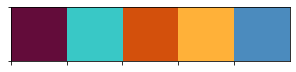

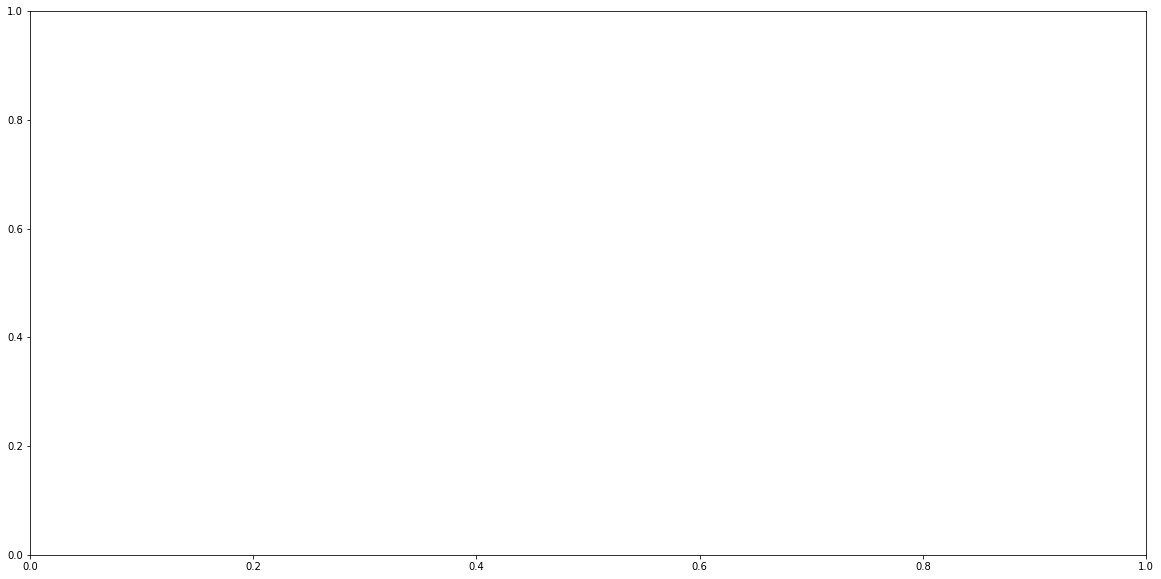

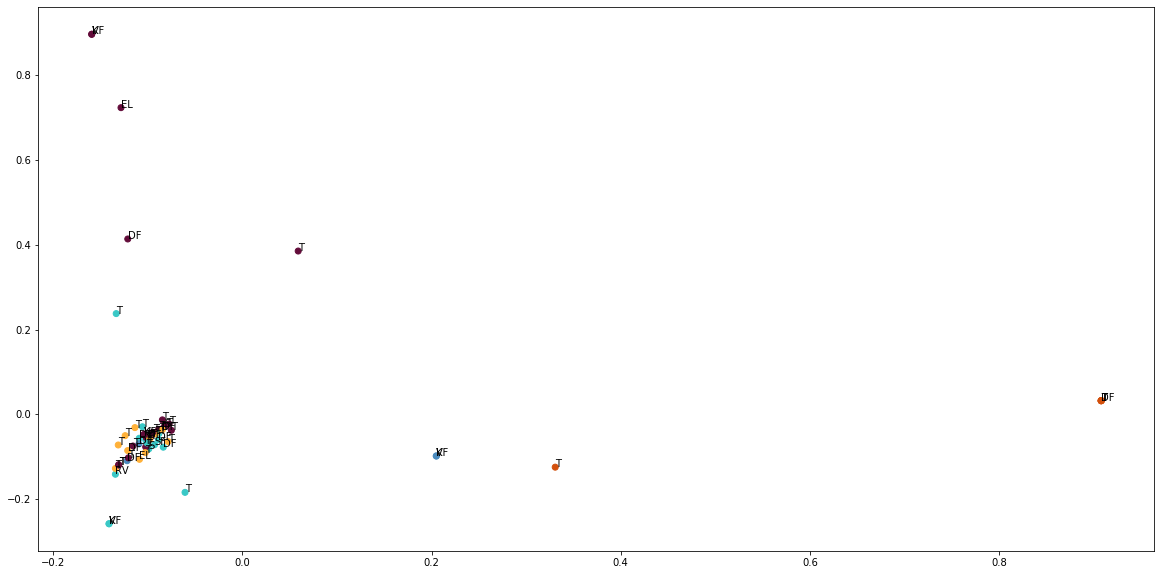

In [7]:
df_s = pd.DataFrame()   
nr = [2,3,4,5,6,7,8,9,10,11]
for i in nr:
   df_s = df_s.append(df_m.iloc[i])
df_s["Parti"] # Make sure no obervations have missing parties.
# for i in range(len(df_s)):
#    Tekst_tot2 = df_s.iloc[i]["Tekst"].split(",")[1:-1] # put all individual sentences from all rows into one list.
# Tekst_tot2 = df_s["Tekst"].str.cat(sep=" ")
# Tekst_tot2 = Tekst_tot2.split(".")[1:-1]   
text = df_s["Tekst"].str.cat(sep=" ") # put all text instances from all rows into one string.
Tekst_tot2 = nltk.tokenize.sent_tokenize(text) # put all individual sentences from all rows into one list.

# Make an orderd list which contains which party every sentence was said by. 
parti = []
for i in range(len(df_s)):
   sentences = nltk.tokenize.sent_tokenize(df_s.iloc[i]["Tekst"])
   for j in sentences: # Iterate every sentence
      parti.append(df_s.iloc[i]["Parti"]) # Add the same party that the sentences belong to as many times as we have sentences
      
len(parti) == len(Tekst_tot2) # Make sure both lists have the same lengths.  

vectorizer2 = TfidfVectorizer(stop_words=stopord)
X2 = vectorizer2.fit_transform(Tekst_tot2)
model2 = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=1)
model2_indices = model2.fit_predict(X2)
# model2_indices = pd.DataFrame(model2_indices, columns=["cluster"])
# group = model2_indices.groupby("cluster")

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X2.toarray())

# Make full array containing coordinates of each sentence and party that each point (sentence) belongs.
coord_parti = np.append(scatter_plot_points, np.array([parti]).T, 1)
coord_parti.shape # Make sure dimensions are still correct (59, 3).
coord_parti = pd.DataFrame(coord_parti, columns=["x", "y", "label"]) # Convert to pandas dataframe for simplicity latter on.
coord_parti.head()

# Make some nice colors
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', "#4B8BBE"]
sns.set_palette(customPalette)
sns.palplot(customPalette)

# Make plot of data points and clusters.
fig, ax = plt.subplots(figsize=(20,10))
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[customPalette[d] for d in model2_indices])
   
for i, txt in enumerate(parti):
    ax.annotate(txt, (x_axis[i], y_axis[i]))


In [ ]:
# Fancier plot (Not working!)
# Make some nice colors
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', "#4B8BBE"]
sns.set_palette(customPalette)
sns.palplot(customPalette)q
# Make plot of data points and clusters.
fig, axes = plt.subplots(figsize=(20,10))
#loop through labels and plot each cluster
for i, label in enumerate(group.groups.keys()):

    #loop through data points and plot each point 
    for l, row in coord_parti.loc[coord_parti['label']==label,:].iterrows():
    
        #add the data point as text
        plt.annotate(row['label'], 
                     (row['x'], row['y']),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=11,
                     color=customPalette[i])


## Running on full dataset

The memory runs out so a more concentrated dataset needs to be used.

In [ ]:
# Use TfidfVectorizer to create class to fit and transform document.
vectorizer = TfidfVectorizer(stop_words=stopord)
X = vectorizer.fit_transform(Tekst_tot)
true_k = 100
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=1)
model.fit(X)

# Make an orderd list which contains which party every sentence was said by. 
parti = []
for i in range(len(df_m)):
   sentences = nltk.tokenize.sent_tokenize(df_m.iloc[i]["Tekst"])
   # print(i)
   # print(len(sentences))
   # print(sentences)
   for j in sentences: # Iterate every sentence
      # print(j)
      parti.append(df_m.iloc[i]["Parti"]) # Add the same party that the sentences belong to as many times as we have sentences
      
len(parti) == len(Tekst_tot) # Make sure both lists have the same lengths.  

model_indices = model.fit_predict(X)
# model2_indices = pd.DataFrame(model2_indices, columns=["cluster"])
# group = model2_indices.groupby("cluster")

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray()) # Give 2D coordinates to each sentence

# Make full array containing coordinates of each sentence and party that each point (sentence) belongs.
coord_parti = np.append(scatter_plot_points, np.array([parti]).T, 1)
coord_parti.shape # Make sure dimensions are still correct (59, 3).
coord_parti = pd.DataFrame(coord_parti, columns=["x", "y", "label"]) # Convert to pandas dataframe for simplicity latter on.
coord_parti.head()


In [ ]:
# Make plot

# Make a color for each cluster
import random
number_of_colors = true_k
customPalette = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
#customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', "#4B8BBE"]
sns.set_palette(customPalette)
sns.palplot(customPalette)

# Make plot of data points and clusters.
fig, ax = plt.subplots(figsize=(20,10))
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[customPalette[d] for d in model2_indices])
   
for i, txt in enumerate(parti):
    ax.annotate(txt, (x_axis[i], y_axis[i]))
